In [1]:

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,root_mean_squared_error
from category_encoders import TargetEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from tqdm import tqdm
import shap
import lime.lime_tabular
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

sys.path.append("../utils")

# Import the data_loader module
import data_loader, data_processor, plots
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
import optuna  # For Bayesian optimization
import os
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin





In [2]:
merged_macro_transactions_df = pd.read_parquet("../datasets/processed/merged_macro_transactions.parquet", engine='fastparquet')
# property_transactions_df = pd.read_parquet("../datasets/processed/property_transactions.parquet", engine='fastparquet')
# property_rental_transactions_df = pd.read_parquet("../datasets/processed/property_rental_transactions_required.parquet", engine='fastparquet')

sales_model_features_df = pd.read_parquet("../datasets/processed/full_sales_df.parquet", engine='fastparquet')
rentals_model_features_df = pd.read_parquet("../datasets/processed/full_rentals_df.parquet", engine='fastparquet')

In [3]:
sales_model_features_df.drop(columns='Transaction Date', inplace=True)
sales_model_features_df.head(2)

,Parking,Property Size (sq.m),No. of Buyer,No. of Seller,Transaction Size (sq.m),Sale Price,Usage,Property Sub Type,Room(s),Nearest Metro,...,Year,Month,Day,Hour,YearMonth,YearWeek,Price per sq.m,Avg Price Last Month,Avg Price Last Week,Number of Rooms
0,271.705672,600.51,1.0,1.0,600.51,1500000.0,Commercial,Commercial,1 B/R,Buj Khalifa Dubai Mall Metro Station,...,2022,6,2,15,629,2022-22,2497.876805,2498.688452,5150.112859,1.0
1,210.452335,112.24,1.0,1.0,112.24,815000.0,Residential,Residential,1 B/R,Buj Khalifa Dubai Mall Metro Station,...,2022,6,2,15,629,2022-22,7261.225944,7719.686097,8030.465069,1.0


In [4]:
rentals_model_features_df.head(2)

,Parking,Property Size (sq.m),Annual Rental Price,Rental Price,Is Free Hold?,Property Type,Nearest Metro,Usage,Area,Property Sub Type,Nearest Mall,Nearest Landmark,Ejari Contract Number,No of Units,Year
0,0.973568,14965.687721,5000.0,25000.0,Free Hold,Building,Rashidiya Metro Station,Industrial,Dubai Investment Park Second,Factory,Dubai Mall,Expo 2020 Site,120210425000238,1,2021-01-01
1,0.972854,6792.000000,4000000.0,16000000.0,Free Hold,Building,Rashidiya Metro Station,Residential,Um Nahad Third,Building,Dubai Mall,Dubai International Airport,120210526001582,1,2021-01-01


In [5]:
merged_macro_transactions_df.head(2)

,Year,Sales Transactions,Rental Transactions,GDP_constant,GDP_current,total_population,total_population_female,total_population_male,total_population_others,tourism_guests,currency_strength,GDP_per_capita,Tourism_revenue_per_capita,Population_growth_rate,Tourism_growth_rate
0,1997,56,0.0,39555.666789,44201.158943,5457460.0,1823941.0,904789.0,2728730.0,18970378.0,0.272326,0.007248,3.476045,0.045094,-0.009493
1,1998,1309,0.0,39555.666789,44201.158943,5691510.0,1912678.0,933077.0,2845755.0,21949904.0,0.272326,0.006950,3.856605,0.042886,0.157062


To approach the task of developing and evaluating four models for property sale and rental price estimation, we will follow these steps:

**Step 1:** Prepare the Data
- **Transaction Data**: The real estate transaction data should include the following features:
  - **Property Type**
  - **Property Sub Type**
  - **Number of Rooms/Bedrooms**
  - **Property Size (sq.m)**
  - **Area/Neighborhood**
  - **Nearest Metro**
  - **Nearest Mall**
  - **Nearest Landmark**
  - **Usage** (Commercial/Residential)
  - **Average Prices the Previous Month/Week**
  
- **Supplementary Data**: We can enrich the models by integrating supplementary datasets such as:
  - **Macroeconomic indicators** (e.g., GDP growth, population)
  - **Tourism and Currency data**
  - **Consumer Price Index**
  - **Other relevant data** based on the available datasets (e.g., interest rates, real estate market trends)

**Step 2:** Model Development
We will develop **four models** as required: 
1. **Model 1**: Estimating property sale prices using **real estate transaction data** only.
2. **Model 2**: Estimating property rental prices using **real estate transaction data** only.
3. **Model 3**: Estimating property sale prices incorporating **both real estate and supplementary data**.
4. **Model 4**: Estimating property rental prices incorporating **both real estate and supplementary data**.

**Step 3:** Preprocessing and Feature Engineering
1. **Encoding categorical variables** (e.g., Property Type, Area/Neighborhood, Nearest Metro).
2. **Scaling numeric features** (e.g., Property Size, Average Prices).
3. **Handling missing values** (e.g., Imputation or removal of rows with missing critical data).

We can use standard techniques like one-hot encoding for categorical features and normalization or standardization for numerical features.

**Step 4:** Model Training
We can use a range of regression models for estimation, such as:
- **Linear Regression**
- **Decision Tree Regression**
- **Random Forest Regression**
- **Gradient Boosting Machines (GBM)**
- **XGBoost** or **LightGBM**
- **Neural Networks** (if required for more complexity)

We can start by training simpler models (e.g., linear regression) and gradually move to more complex models (e.g., random forest, XGBoost).

**Step 5:** Model Evaluation
Evaluate each model's performance using the following metrics:
- **RMSE** (Root Mean Squared Error)
- **MSE** (Mean Squared Error)
- **R²** (R-squared)

These metrics will help us assess the accuracy of each model. RMSE and MSE will give an indication of how close the predictions are to the actual values, while R² will show how well the model explains the variance in the target variable.

**Step 6:** Performance Comparison
- Compare the performance of the models (Model 1 vs. Model 3 and Model 2 vs. Model 4).
- Assess whether including supplementary data improves accuracy (using RMSE, MSE, and R²) and analyze the impact of each feature.


**Step 7:** Analyze the Impact of Supplementary Data
Once we have trained all four models, compare the results. If the models incorporating supplementary data (Models 3 and 4) show a significant improvement in accuracy, it suggests that macroeconomic factors and external data can enhance the prediction of sale and rental prices. This would confirm that real estate trends are influenced by both local transaction data and broader economic indicators.


In [6]:
rentals_model_features_df.isnull().mean() * 100

Parking                  0.0
Property Size (sq.m)     0.0
Annual Rental Price      0.0
Rental Price             0.0
Is Free Hold?            0.0
Property Type            0.0
Nearest Metro            0.0
Usage                    0.0
Area                     0.0
Property Sub Type        0.0
Nearest Mall             0.0
Nearest Landmark         0.0
Ejari Contract Number    0.0
No of Units              0.0
Year                     0.0
dtype: float64

- If there are processing thet will be handled via the Pipeline
- Let's confirm the state of the selected dataset ahead of modeling

In [7]:
# model_features_df.drop_duplicates(inplace=True)
# model_features_df = data_processor.optimize_dataframe_memory(model_features_df)
data_processor.display_dataframe_info(rentals_model_features_df)

Shape: (4651370, 15)
Dtypes: ['Parking:float32', 'Property Size (sq.m):float64', 'Annual Rental Price:float64', 'Rental Price:float64', 'Is Free Hold?:category', 'Property Type:category', 'Nearest Metro:category', 'Usage:category', 'Area:category', 'Property Sub Type:category', 'Nearest Mall:category', 'Nearest Landmark:category', 'Ejari Contract Number:int64', 'No of Units:int16', 'Year:datetime64[ns]']
Missings (%): ['Parking:0.00%', 'Property Size (sq.m):0.00%', 'Annual Rental Price:0.00%', 'Rental Price:0.00%', 'Is Free Hold?:0.00%', 'Property Type:0.00%', 'Nearest Metro:0.00%', 'Usage:0.00%', 'Area:0.00%', 'Property Sub Type:0.00%', 'Nearest Mall:0.00%', 'Nearest Landmark:0.00%', 'Ejari Contract Number:0.00%', 'No of Units:0.00%', 'Year:0.00%']
Total missings (%): 0.00%
total duplicates: 0
Total memory usage: 279.46 MB


,Parking,Property Size (sq.m),Annual Rental Price,Rental Price,Is Free Hold?,Property Type,Nearest Metro,Usage,Area,Property Sub Type,Nearest Mall,Nearest Landmark,Ejari Contract Number,No of Units,Year
0,0.973568,14965.687721,5000.0,25000.0,Free Hold,Building,Rashidiya Metro Station,Industrial,Dubai Investment Park Second,Factory,Dubai Mall,Expo 2020 Site,120210425000238,1,2021-01-01
1,0.972854,6792.000000,4000000.0,16000000.0,Free Hold,Building,Rashidiya Metro Station,Residential,Um Nahad Third,Building,Dubai Mall,Dubai International Airport,120210526001582,1,2021-01-01


In [8]:
# label_encoders, df   
# data_processor.encode_cat_cols(model_features_df)
# model_features_df[categorical_features].head(2)

- rename target columns to suitable names

In [9]:
sales_model_features_df.columns

Index(['Parking', 'Property Size (sq.m)', 'No. of Buyer', 'No. of Seller',
       'Transaction Size (sq.m)', 'Sale Price', 'Usage', 'Property Sub Type',
       'Room(s)', 'Nearest Metro', 'Nearest Mall', 'Nearest Landmark',
       'Transaction Number', 'Property ID', 'Transaction Type',
       'Transaction sub type', 'Registration type', 'Is Free Hold?', 'Area',
       'Property Type', 'Year', 'Month', 'Day', 'Hour', 'YearMonth',
       'YearWeek', 'Price per sq.m', 'Avg Price Last Month',
       'Avg Price Last Week', 'Number of Rooms'],
      dtype='object')

- seperate numerical features from non-numericals

In [10]:
rentals_merged_numerical_features =   rentals_model_features_df.select_dtypes(include=[np.number]).columns
rentals_merged_categorical_features = rentals_model_features_df.select_dtypes(exclude=[np.number]).columns

sales_merged_numerical_features =   sales_model_features_df.select_dtypes(include=[np.number]).columns
sales_merged_categorical_features = sales_model_features_df.select_dtypes(exclude=[np.number]).columns

In [11]:

print('numerical_features:', rentals_merged_numerical_features)
print("-"*50)
print('cateforical_features:', rentals_merged_categorical_features)

# model_features_df[categorical_features].head(2)
rentals_model_features_df[rentals_merged_numerical_features].head(2)

numerical_features: Index(['Parking', 'Property Size (sq.m)', 'Annual Rental Price',
       'Rental Price', 'Ejari Contract Number', 'No of Units'],
      dtype='object')
--------------------------------------------------
cateforical_features: Index(['Is Free Hold?', 'Property Type', 'Nearest Metro', 'Usage', 'Area',
       'Property Sub Type', 'Nearest Mall', 'Nearest Landmark', 'Year'],
      dtype='object')


,Parking,Property Size (sq.m),Annual Rental Price,Rental Price,Ejari Contract Number,No of Units
0,0.973568,14965.687721,5000.0,25000.0,120210425000238,1
1,0.972854,6792.000000,4000000.0,16000000.0,120210526001582,1


- check for correlations between targets and within features


 Correlation Heatmap for Numerical Features (Sales):


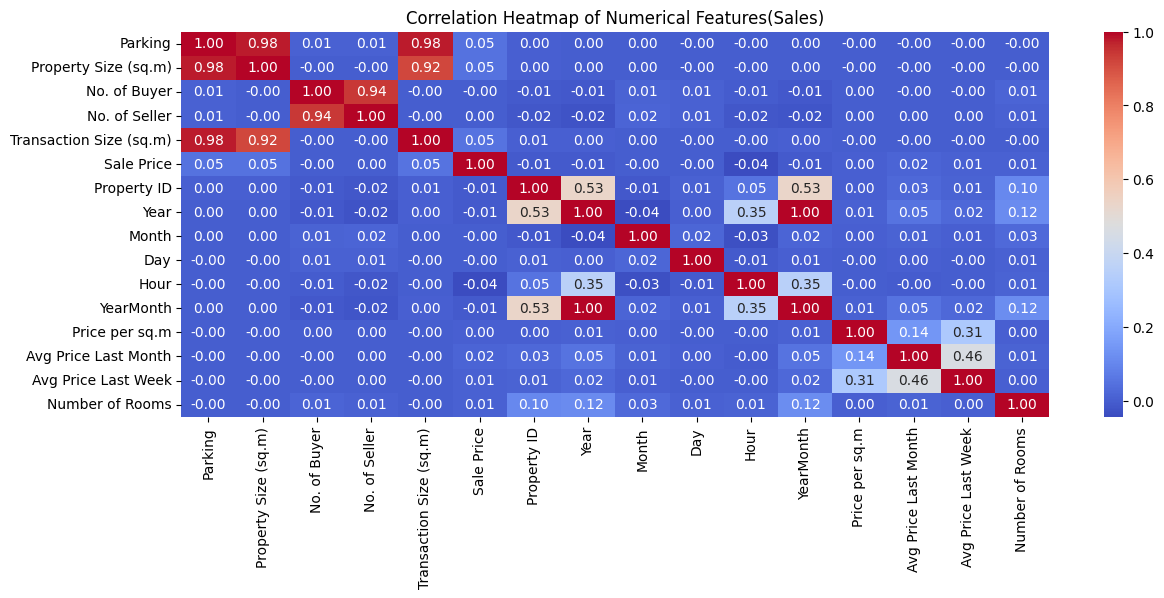

Correlation Matrix for Selected Model Features(Sales):


,Parking,Property Size (sq.m),No. of Buyer,No. of Seller,Transaction Size (sq.m),Sale Price,Property ID,Year,Month,Day,Hour,YearMonth,Price per sq.m,Avg Price Last Month,Avg Price Last Week,Number of Rooms
Parking,1.000000,0.979442,0.008168,0.008018,0.977983,0.048347,0.004288,0.001496,0.000288,-0.001087,-0.001178,0.001515,-0.000062,-0.000397,-0.000191,-0.001383
Property Size (sq.m),0.979442,1.000000,-0.000371,-0.000376,0.916798,0.046918,0.004316,0.001232,0.000301,-0.000866,-0.001666,0.001251,-0.000051,-0.000337,-0.000161,-0.001740
No. of Buyer,0.008168,-0.000371,1.000000,0.939428,-0.000392,-0.001992,-0.007782,-0.014658,0.012753,0.005868,-0.005749,-0.013889,0.000021,-0.000197,-0.000082,0.014314
No. of Seller,0.008018,-0.000376,0.939428,1.000000,-0.000390,0.000611,-0.016518,-0.023466,0.015142,0.007378,-0.016861,-0.022558,0.000002,0.000253,0.000092,0.009482
Transaction Size (sq.m),0.977983,0.916798,-0.000392,-0.000390,1.000000,0.054540,0.005043,0.002536,0.000050,-0.001490,-0.000668,0.002541,-0.000044,-0.000287,-0.000138,-0.001386
Sale Price,0.048347,0.046918,-0.001992,0.000611,0.054540,1.000000,-0.010474,-0.010461,-0.000775,-0.000878,-0.041522,-0.010516,0.003137,0.017014,0.008536,0.007915
Property ID,0.004288,0.004316,-0.007782,-0.016518,0.005043,-0.010474,1.000000,0.531792,-0.010788,0.006153,0.052048,0.531545,0.004260,0.025489,0.012147,0.103861
Year,0.001496,0.001232,-0.014658,-0.023466,0.002536,-0.010461,0.531792,1.000000,-0.043243,0.003908,0.353055,0.998132,0.007510,0.052225,0.023974,0.115351
Month,0.000288,0.000301,0.012753,0.015142,0.000050,-0.000775,-0.010788,-0.043243,1.000000,0.018609,-0.032440,0.017879,0.001752,0.012211,0.005599,0.029519
Day,-0.001087,-0.000866,0.005868,0.007378,-0.001490,-0.000878,0.006153,0.003908,0.018609,1.000000,-0.009043,0.005049,-0.000938,0.002577,-0.002281,0.005786


In [12]:

# Correlation heatmap for numerical features
print("\n Correlation Heatmap for Numerical Features (Sales):")
plt.figure(figsize=(14, 5))
corr_matrix_sales = sales_model_features_df[sales_merged_numerical_features].corr()
sns.heatmap(
    corr_matrix_sales, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    cbar=True
)
plt.title("Correlation Heatmap of Numerical Features(Sales)")
plt.show()

print("Correlation Matrix for Selected Model Features(Sales):")
corr_matrix_sales


- **`Important considerations`**

1. ***Model Selection and Diversity***
- Ensemble Models:
   - A combination of models (e.g., Random Forest, XGBoost, LightGBM) and stack them to create a meta-model.
   - Blending and bagging techniques for more robust predictions.
- Deep Learning: If feasible, a neural network (e.g., MLP or Transformer-based architecture) for high-dimensional or temporal data can be utilized
- Baseline Comparisons: Clear comparisons between simple models (e.g., linear regression) and advanced techniques to highlight the improvements.

2. ***Dataset Preparation and Enrichment***
- Data Quality: no missing values, duplicates, and outliers. No imbalances (mostly for classification)

- Feature Engineering:
  - Interaction terms, ratios, and normalized metrics can be created to.
  - Temporal Features like month, seasonality, or time trends from date columns.
  - Geospatial Features  like distance to landmarks or metro.
  - External Data like economic indicators (supplied), regional trends, or weather data  to enhance the model's context.

3. ***Hyperparameter Tuning***
- Systematic Searches like Bayesian optimization or Randomized Search instead of exhaustive grid search for more efficient hyperparameter tuning.
- Early Stopping criteria during training to avoid overfitting

4. ***Explainability***
- Feature Importance:
  - SHAP or LIME for contribution of each feature to predictions.
  - Bar plots or heatmaps of feature importances.
- Model Interpretation: Include insights into why certain models performed better and which features drive predictions.
- Documentation of choices made and methodology

5. ***Robustness Testing***
- Cross-Validation to ensure results are stable across multiple folds or random seeds.
- Error Analysis:
  - Investigation of poorly performed models.
  - Grouping errors by key features (e.g., property type, location) to identify systematic biases. 
  -  Cross-Validation RMSE, Test RMSE, MAE, and R².
- Generalizability: Testing of models on unseen subsets or simulating real-world scenarios.
- Handling Overfitting/Underfitting using train-test-val sets to ensure models generalize well to unseen data.

- Train-Test Split: Incorporate a holdout test set for final evaluation. This ensures models generalize well to unseen data:

6. ***Computational Efficiency***
Optimize runtime by:
- Using smaller, representative datasets for initial experiments.
- Leveraging GPU/TPU acceleration for computationally heavy models.
- Profiling your code to identify bottlenecks.
- Setting `n_jobs=-1` for both GridSearchCV and models (like Random Forest or XGBoost) to fully utilize computational resources.


7. ***Practical Application and Insights***
- Actionable Insights of practical takeaways for real estate stakeholders:
  - Identify key drivers of sale/rental prices.
  - Highlight undervalued areas or segments with growth potential.
- Scenario Simulation:
   - Predicting how changes in external factors (e.g., population growth, metro proximity) might influence prices.
   - Evaluating the impact of economic indicators on model predictions.

8. **Final Touches**
- Logging and Saving Results of `best_models `and `metrics` as JSON/pickle or CSV for easy retrieval
- Visualizing Results by plotting RMSE, MAE, and R² for easier comparison of model performances
- Pipeline Automation: Packaging of pipeline for easy reproducibility (e.g., use joblib or pickle to save models, snakemake or prefect for orchestration).
- Clean and Modular Code organized as scripts into reusable modules for data preprocessing, feature engineering, modeling, and evaluation.
- Deployment-Ready Solution:
  - Creating a simple interface (e.g., Streamlit or Flask) to demonstrate predictions for new data inputs.
  - Showcasing a real-time prediction demo if possible.

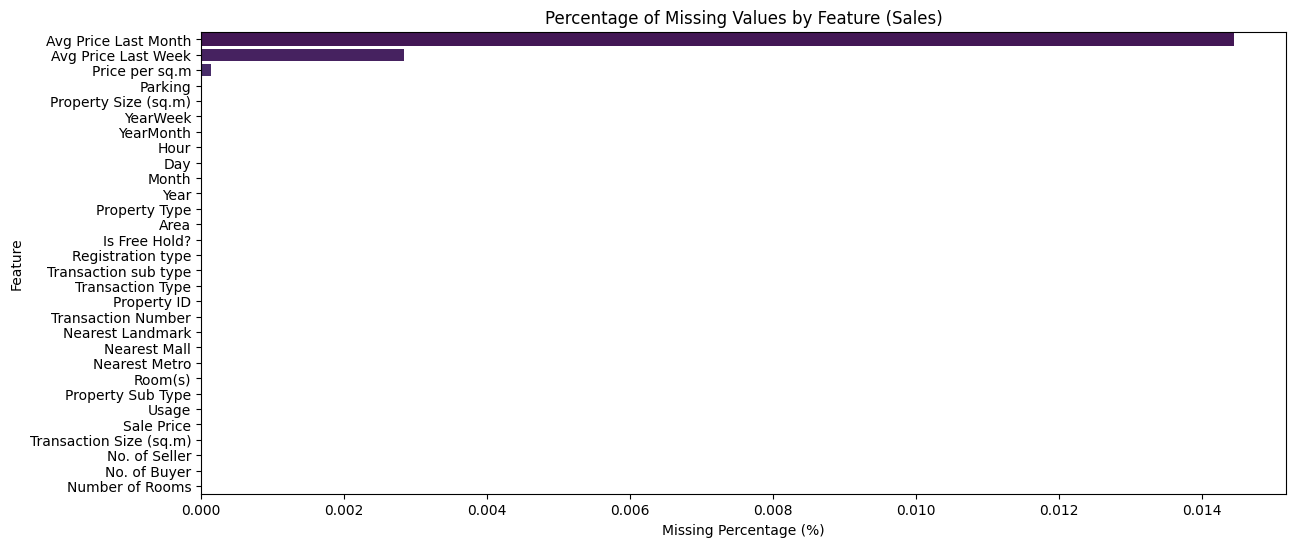

                                         Feature  MissingPercent
Avg Price Last Month        Avg Price Last Month        0.014446
Avg Price Last Week          Avg Price Last Week        0.002832
Price per sq.m                    Price per sq.m        0.000142
Parking                                  Parking        0.000000
Property Size (sq.m)        Property Size (sq.m)        0.000000
YearWeek                                YearWeek        0.000000
YearMonth                              YearMonth        0.000000
Hour                                        Hour        0.000000
Day                                          Day        0.000000
Month                                      Month        0.000000
Year                                        Year        0.000000
Property Type                      Property Type        0.000000
Area                                        Area        0.000000
Is Free Hold?                      Is Free Hold?        0.000000
Registration type        

In [13]:
def visualize_missing_values(df, title="Percentage of Missing Values by Feature"):
    """
    Calculates and visualizes the percentage of missing values for each feature in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - title (str): The title for the visualization.

    Returns:
    - pd.DataFrame: A DataFrame with missing percentages for each feature.
    """
    # Calculate missing values and percentages
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Feature': missing_values.index,
        'MissingPercent': missing_percent
    }).sort_values(by='MissingPercent', ascending=False)

    # Visualize missing values
    plt.figure(figsize=(14, 6))
    sns.barplot(data=missing_df, y='Feature', x='MissingPercent', palette='viridis',hue='Feature', legend=False)
    plt.title(title)
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("Feature")
    plt.show()
    
    return missing_df

# Analyze and visualize missing values in the merged_real_estate_df
missing_sales_model_features_df = visualize_missing_values(
    df=sales_model_features_df,
    title="Percentage of Missing Values by Feature (Sales)"
)

# Display the summary DataFrame
print(missing_sales_model_features_df)


- low percentage missings will be handle by the pipeline

In [14]:
print("number of numerical features(sales):",  len(sales_merged_numerical_features))
sales_model_features_df[sales_merged_numerical_features].describe().T

number of numerical features(sales): 16


,count,mean,std,min,25%,50%,75%,max
Parking,706096.0,4.088615e+02,6.871545e+04,-2.588073e+04,156.936470,2.035061e+02,2.218264e+02,5.438286e+07
Property Size (sq.m),706096.0,1.593715e+03,4.621819e+05,0.000000e+00,68.000000,1.076100e+02,1.994600e+02,3.421034e+08
No. of Buyer,706096.0,1.289718e+00,7.676754e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,3.134000e+03
No. of Seller,706096.0,1.254743e+00,6.880034e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.084000e+03
Transaction Size (sq.m),706096.0,1.331393e+03,4.218596e+05,-4.650505e+03,46.170000,9.746000e+01,2.025000e+02,3.421034e+08
Sale Price,706096.0,2.412807e+06,9.750614e+06,6.751000e+01,649391.500000,1.192111e+06,2.150000e+06,1.247541e+09
Property ID,706096.0,1.282693e+08,2.653951e+08,2.946000e+03,684347.250000,2.407754e+07,6.483417e+07,1.257530e+09
Year,706096.0,2.014367e+03,4.660155e+00,1.997000e+03,2010.000000,2.014000e+03,2.018000e+03,2.022000e+03
Month,706096.0,6.389597e+00,3.417254e+00,1.000000e+00,3.000000,6.000000e+00,9.000000e+00,1.200000e+01
Day,706096.0,1.591556e+01,8.754388e+00,1.000000e+00,8.000000,1.600000e+01,2.400000e+01,3.100000e+01


In [15]:
sales_model_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706096 entries, 0 to 706095
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Parking                  706096 non-null  float64 
 1   Property Size (sq.m)     706096 non-null  float64 
 2   No. of Buyer             706096 non-null  float32 
 3   No. of Seller            706096 non-null  float32 
 4   Transaction Size (sq.m)  706096 non-null  float64 
 5   Sale Price               706096 non-null  float64 
 6   Usage                    706096 non-null  category
 7   Property Sub Type        706096 non-null  category
 8   Room(s)                  706096 non-null  category
 9   Nearest Metro            706096 non-null  category
 10  Nearest Mall             706096 non-null  category
 11  Nearest Landmark         706096 non-null  category
 12  Transaction Number       706096 non-null  object  
 13  Property ID              706096 non-null  in

In [16]:
print("number of categorical features(Sales):",  len(sales_merged_categorical_features))
sales_model_features_df[sales_merged_categorical_features].describe().T

number of categorical features(Sales): 14


,count,unique,top,freq
Usage,706096,2,Residential,663246
Property Sub Type,706096,43,Flat,451904
Room(s),706096,16,1 B/R,320030
Nearest Metro,706096,58,Buj Khalifa Dubai Mall Metro Station,213788
Nearest Mall,706096,7,Marina Mall,404158
Nearest Landmark,706096,16,Sports City Swimming Academy,244312
Transaction Number,706096,704810,11-14597-2011,317
Transaction Type,706096,1,Sales,706096
Transaction sub type,706096,18,Sale,320565
Registration type,706096,2,Ready,446868


In [17]:
# sales_model_features_df['Year'] = pd.to_datetime(sales_model_features_df['Year'])
# print('Sales Dtype for Year:', sales_model_features_df['Year'].dtypes)


---

**Numerical Features**:
1. **`Property Size (sq.m)` and `Sale Price`**: These features show significant variability, with extremely high maximum values. This could indicate outliers (e.g., unusually large properties or luxury real estate transactions) or potential data errors. Careful scaling or capping might be required during preprocessing.
2. **`Parking`**: The presence of negative values is unusual and indicates data errors (e.g., "-10" should be corrected to a valid number or treated as missing data).
3. **`Avg Price per sq.m Last Month`**: The minimum value is very close to zero, which may be an error, especially if unrealistic.
4. Features like **`Year`** and **`YearMonth`** represent time series and need no additional scaling but might be transformed to create trends or seasonality features.
5. Overall, numerical features contain a mix of clean and noisy data. Features with unusually high variances will need special treatment, either by normalization or robust scaling.

---

**Categorical Features**:
1. **`Property Sub Type`** and **`Area`**: These have many unique values, which might require dimensionality reduction techniques such as target encoding or clustering.
2. **`Nearest Metro` and `Nearest Landmark`**: The top values indicate strong regional clustering, which aligns with geographical dependency in real estate markets.
3. **`Usage`** and **`Is Free Hold?`**: These binary features are clean and ready for encoding.
4. **`YearWeek`**: With over 1,200 unique values, encoding might be tricky. It can be simplified into broader periods, such as quarters or seasons.

---


To better understand the anomalies in features like **`Property Size (sq.m)`**, **`Sale Price`**, **`Parking`**, and **`Avg Price per sq.m Last Month`**, let's investigate the rows where these anomalies occur. This analysis will be linked with other columns like **`Year`**, **`Area`**, and **`Property Sub Type`** to gain insights into the patterns behind these anomalies.

***Investigation Steps***:
1. **Identify and Extract Rows with Anomalies**:
   - For each selected feature, filter rows with values that are out of range or seem unrealistic.
   - Define thresholds based on data distribution (e.g., lower than the 1st percentile or higher than the 99th percentile).

2. ***Link to Key Columns***:
   - Add contextual columns such as `Year`, `Area`, `Property Sub Type`, and others.

3. ***Summarize Patterns***:
   - Identify if anomalies are concentrated in specific years, areas, or property types.

---

**Step 1: Outlier Detection and Contextual Linking**

In [18]:
# Define thresholds for outlier detection
def investigate_anomalies(df, feature, low_quantile=0.01, high_quantile=0.99):
    q_low = df[feature].quantile(low_quantile)
    q_high = df[feature].quantile(high_quantile)
    anomalies = df[(df[feature] < q_low) | (df[feature] > q_high)]
    return anomalies

# Investigate selected features
anomaly_reports = {}
features_to_investigate = [
    'Property Size (sq.m)', 'Sale Price', 'Parking', 'Avg Price Last Month'
]


In [19]:
sales_model_features_df.columns

Index(['Parking', 'Property Size (sq.m)', 'No. of Buyer', 'No. of Seller',
       'Transaction Size (sq.m)', 'Sale Price', 'Usage', 'Property Sub Type',
       'Room(s)', 'Nearest Metro', 'Nearest Mall', 'Nearest Landmark',
       'Transaction Number', 'Property ID', 'Transaction Type',
       'Transaction sub type', 'Registration type', 'Is Free Hold?', 'Area',
       'Property Type', 'Year', 'Month', 'Day', 'Hour', 'YearMonth',
       'YearWeek', 'Price per sq.m', 'Avg Price Last Month',
       'Avg Price Last Week', 'Number of Rooms'],
      dtype='object')

---

Step 2: Patterns and Insights

1. Group by Contextual Columns:
   - Check if anomalies are clustered by Year, Area, or Property Sub Type.

In [20]:
sales_model_features_df[['Year', 'Area', 'Property Sub Type', 'Number of Rooms',
                   'Room(s)','Sale Price']].head(2)

,Year,Area,Property Sub Type,Number of Rooms,Room(s),Sale Price
0,2022,AL FURJAN,Commercial,1.0,1 B/R,1500000.0
1,2022,AKOYA OXYGEN,Residential,1.0,1 B/R,815000.0


In [21]:
for feature in features_to_investigate:
    anomalies = investigate_anomalies(sales_model_features_df, feature)
    anomaly_reports[feature] = anomalies[['Year', 'Area', 'Property Sub Type', feature]]
    print(f"\nAnomalies for {feature} (count: {len(anomalies)}):")
    display(anomalies[['Year', 'Area', 'Property Sub Type', feature]])

# Combine all anomalies for holistic review
combined_anomalies = pd.concat(anomaly_reports.values(), keys=anomaly_reports.keys())



Anomalies for Property Size (sq.m) (count: 13940):


,Year,Area,Property Sub Type,Property Size (sq.m)
7,2022,BUSINESS BAY,Hotel Apartment,15.12
31,2022,INTERNATIONAL CITY PH 1,Commercial,75533.92
40,2022,INTERNATIONAL CITY PH 1,Commercial,494565.45
60,2022,DUBAI MARINA,Hotel Rooms,7.44
74,2022,BUSINESS BAY,Hotel Apartment,15.12
...,...,...,...,...
706039,1998,Um Suqaim,Flat,18915.05
706040,1997,Um Suqaim,Residential,4830.21
706050,1997,Um Suqaim,Residential,5128.25
706054,1997,Jumeirah,Residential,4814.23



Anomalies for Sale Price (count: 14118):


,Year,Area,Property Sub Type,Sale Price
31,2022,INTERNATIONAL CITY PH 1,Commercial,75533.92
59,2022,JUMEIRAH LAKES TOWERS,Office,110000.00
132,2022,MBR DISTRICT 1,Residential,28500768.00
143,2022,Mena Jabal Ali,Commercial,142707.68
149,2022,Mena Jabal Ali,Commercial,26362.59
...,...,...,...,...
705989,1998,Hor Al Anz East,Commercial,53060000.00
706007,1998,Al Garhoud,Commercial,44280000.00
706029,1998,Zareeba Duviya,Commercial,65000000.00
706053,1997,Port Saeed,Commercial,22000000.00



Anomalies for Parking (count: 13962):


,Year,Area,Property Sub Type,Parking
25,2022,DUBAI HILLS,Residential Flats,-51.121973
31,2022,INTERNATIONAL CITY PH 1,Commercial,12137.769620
33,2022,DUBAI HILLS,Residential,-81.712723
34,2022,DUBAI HILLS,Residential,-81.712723
40,2022,INTERNATIONAL CITY PH 1,Commercial,78749.437967
...,...,...,...,...
705963,1998,Mirdif,Residential,1440.363941
705998,1998,Al Khawaneej,Agricultural,10075.274633
706029,1998,Zareeba Duviya,Commercial,-985.620226
706039,1998,Um Suqaim,Flat,2764.857523



Anomalies for Avg Price Last Month (count: 13646):


,Year,Area,Property Sub Type,Avg Price Last Month
129,2022,BLUEWATERS,Flat,33685.044831
860,2022,PALM JUMEIRAH,Flat,31635.002244
916,2022,PALM JUMEIRAH,Flat,31635.002244
919,2022,PALM JUMEIRAH,Flat,31635.002244
926,2022,PALM JUMEIRAH,Flat,31635.002244
...,...,...,...,...
705611,1998,Al Sabkha,Commercial,39711.791888
705659,1998,Al-Riqqa West,Commercial,508378.048803
705764,1998,Al-Riqqa West,Commercial,508378.048803
705931,1998,Al Ras,Commercial,64516.129032


2. Visualize Patterns:
   - Use scatter plots to observe the distribution of anomalies across years and areas.

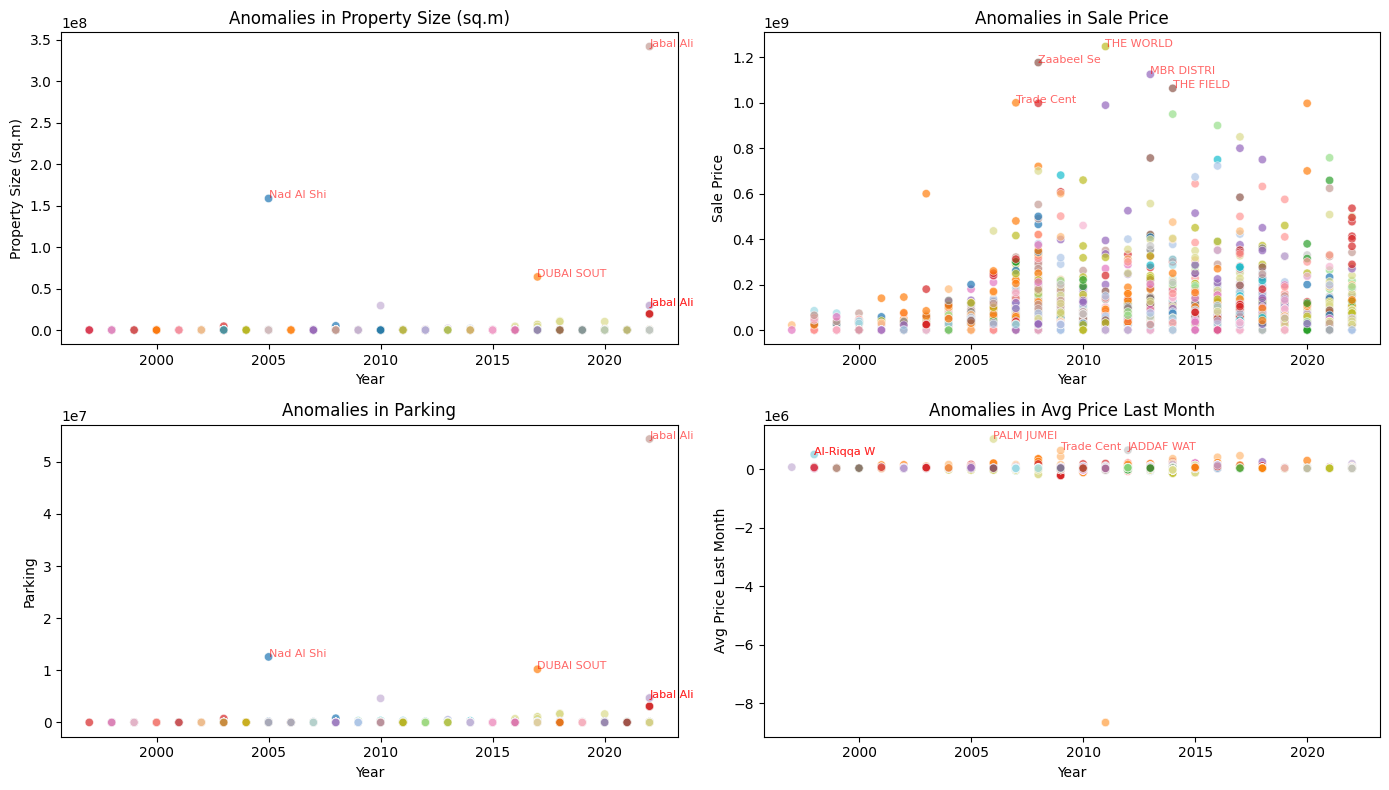

In [22]:
def plot_anomalies_optimized(anomaly_reports, features_to_investigate, annotate_limit=10):
    """
    Optimized plotting function for anomalies with reduced annotations.

    Parameters:
        anomaly_reports (dict): Dictionary with features as keys and anomaly DataFrames as values.
        features_to_investigate (list): List of features to plot anomalies for.
        annotate_limit (int): Maximum number of points to annotate per feature.
    """
    plt.figure(figsize=(14, 4 * len(features_to_investigate) // 2))

    for idx, feature in enumerate(features_to_investigate, start=1):
        plt.subplot((len(features_to_investigate) + 1) // 2, 2, idx)
        
        # Scatterplot with anomalies highlighted
        ax = sns.scatterplot(
            data=anomaly_reports[feature],
            x='Year',
            y=feature,
            hue='Area',
            palette='tab20',
            alpha=0.7,
            legend=False
        )
        
        # Select the most extreme anomalies to annotate
        top_anomalies = anomaly_reports[feature].nlargest(annotate_limit, feature)

        # Indicating only top N data points with annotations
        for _, row in top_anomalies.iterrows():
            ax.text(
                x=row['Year'],
                y=row[feature],
                s=f"{row['Area'][:10]}",
                fontsize=8,
                color="red",
                alpha=0.6
            )
        
        plt.title(f"Anomalies in {feature}")
        plt.tight_layout()

    plt.show()

plot_anomalies_optimized(anomaly_reports, features_to_investigate, annotate_limit=5)


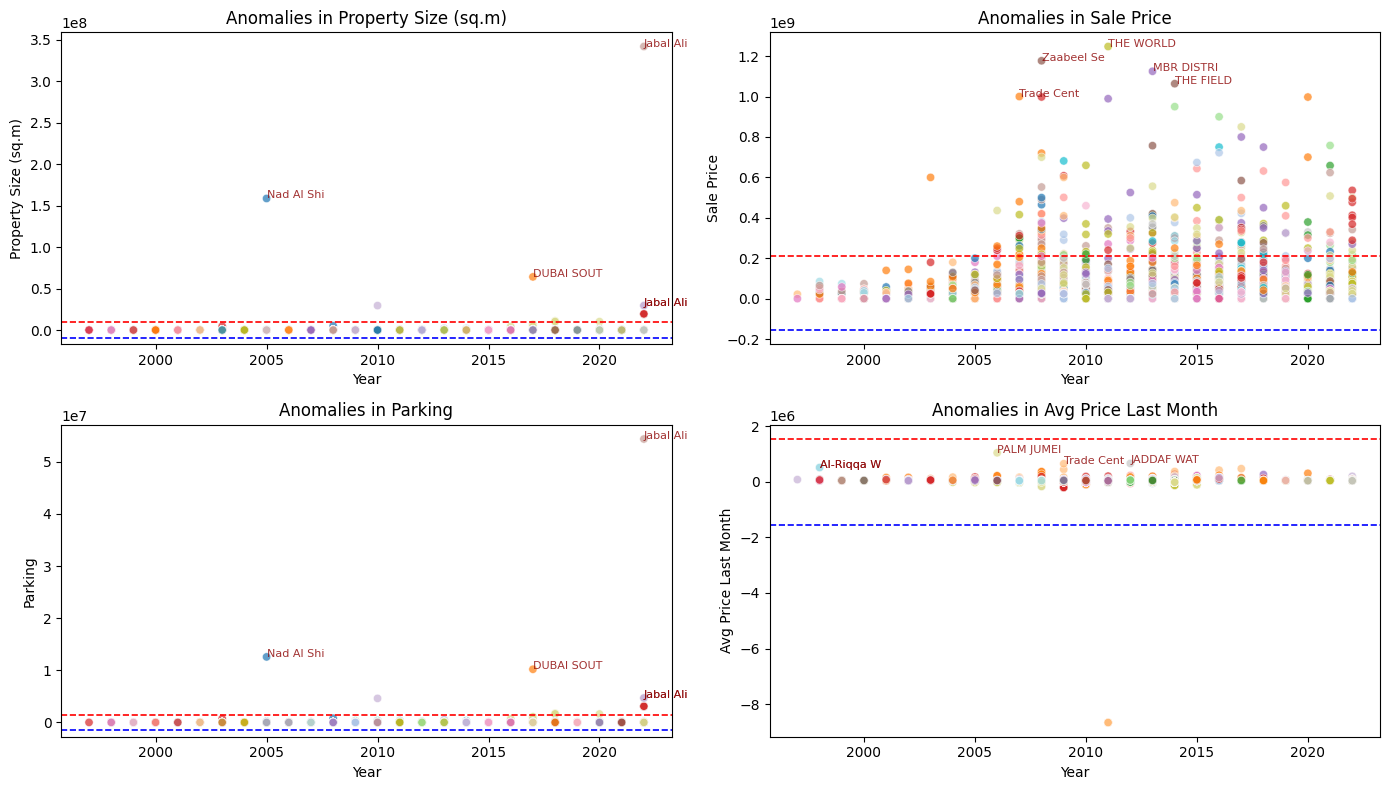

In [23]:
def plot_anomalies_with_threshold(anomaly_reports, features_to_investigate, annotate_limit=5):
    """
    Plot anomalies with extreme values annotated and horizontal line to show thresholds.

    Parameters:
        anomaly_reports (dict): Dictionary with features as keys and anomaly DataFrames as values.
        features_to_investigate (list): List of features to plot anomalies for.
        annotate_limit (int): Maximum number of points to annotate per feature.
    """
    plt.figure(figsize=(14, 4 * len(features_to_investigate) // 2))

    for idx, feature in enumerate(features_to_investigate, start=1):
        plt.subplot((len(features_to_investigate) + 1) // 2, 2, idx)

        # Scatterplot with anomalies highlighted
        ax = sns.scatterplot(
            data=anomaly_reports[feature],
            x='Year',
            y=feature,
            hue='Area',
            palette='tab20',
            alpha=0.7,
            legend=False
        )

        # Calculate and draw the threshold line for outliers
        feature_values = anomaly_reports[feature][feature]
        threshold_upper = feature_values.mean() + 3 * feature_values.std()
        threshold_lower = feature_values.mean() - 3 * feature_values.std()

        # Add horizontal lines for thresholds
        ax.axhline(y=threshold_upper, color='red', linestyle='--', linewidth=1.2, label="Upper Threshold")
        ax.axhline(y=threshold_lower, color='blue', linestyle='--', linewidth=1.2, label="Lower Threshold")

        # Annotate only the top N anomalies
        top_anomalies = anomaly_reports[feature].nlargest(annotate_limit, feature)
        for _, row in top_anomalies.iterrows():
            ax.text(
                x=row['Year'],
                y=row[feature],
                s=f"{row['Area'][:10]}",
                fontsize=8,
                color="darkred",
                alpha=0.8
            )
        
        plt.title(f"Anomalies in {feature}")
        plt.xlabel('Year')
        plt.ylabel(feature)
        plt.legend([], [], frameon=False)  # Remove legend for cleaner visualization
        plt.tight_layout()

    plt.show()

plot_anomalies_with_threshold(anomaly_reports, features_to_investigate, annotate_limit=5)


**Observations and Insights from the Anomaly Investigation**

 1. **`Property Size (sq.m)`**
   - ***Key Insights***:
     - Values range from very small sizes (e.g., **7.44 sq.m** for "Hotel Rooms") to extremely large sizes (e.g., **494,565.45 sq.m** for "Commercial" properties).
     - Large sizes are mainly observed in **industrial**, **agricultural**, and **commercial** areas like **Ras Al Khor** and **Al Khawaneej**.
     - Small sizes are concentrated in residential or hotel properties.
   - **Patterns**:
     - Significant outliers occur in both directions, likely influenced by property subtypes.

---

 2. **`Sale Price`**
   - **Key Insights**:
     - Low prices (e.g., **AED 66,500**) appear for flats in less central areas like **Dubai Production City**.
     - High prices (e.g., **AED 65 million**) are associated with commercial properties in prime locations like **Zareeba Duviya** and **Hor Al Anz East**.
   - **Patterns**:
     - Outliers often represent either low-priced flats or high-value commercial properties.
     - Prices are linked to property subtypes and area demand.

---

3. **`Parking`**
   - **Key Insights**:
     - Negative parking values (e.g., **-1**) likely represent data errors.
     - Extremely high parking counts (e.g., **2042** in **Jumeirah Village Circle**) might indicate shared or public parking lots.
   - **Patterns**:
     - Unrealistic values occur in residential flats, particularly in **Dubai Marina** and **The Greens**.

---

4. **`Avg Price per sq.m Last Month`**
   - **Key Insights**:
     - Some extremely low values (e.g., **1 AED/sq.m**) are likely incorrect, especially for commercial areas.
     - Very high values (e.g., **75,349.84 AED/sq.m**) occur in select areas like **Al Buteen**.
   - **Patterns**:
     - Outliers are linked to both commercial and residential areas, depending on the locality and year.

---


Further Actions

1. **Clean Specific Features**:
   - Treat outliers by capping extreme values based on percentiles or logical thresholds.
   - Replace negative values (e.g., **Parking = -1**) with appropriate defaults or impute based on similar records.

2. **Create Derived Features**:
   - **Price-to-Size Ratios**: Calculate price per sq.m as a new feature for sale and rental prices.
   - **Trend Features**: Use `Year` and `YearMonth` to create moving averages or trend indicators.

3. **Encoding and Clustering**:
   - Apply **target encoding** for high-cardinality columns like `Area` and `Property Sub Type`.
   - Use clustering techniques to group areas with similar pricing or property characteristics.

---


Removing realistic outliers, even if extreme, can strip the model of valuable information about high-value or unique scenarios. We can approach this issue thoughtfully:

---

1. **Categorize Outliers**:
   - Separate **realistic** outliers from **erroneous** ones. For example:
     - **Realistic**: High sale prices for commercial properties in prime areas like Dubai Marina.
     - **Erroneous**: Negative values or impossible values like 1 AED/sq.m for commercial properties.
   - Realistic outliers often align with domain knowledge (e.g., luxury, location).

2. **Analyze High-Density Relationships**:
   - Investigate relationships between features. For instance:
     - **High prices** might correlate with location (`Area`) or property type (`Commercial` or `Hotel Apartment`).
     - **Large property sizes** might align with `Industrial` or `Agricultural` uses.
   - Retain these "high-density" patterns by creating features that better capture these relationships.

3. **Feature Scaling Instead of Removal**:
   - Normalize or log-transform features to reduce the influence of extreme values without outright removal.

4. **Test Impact of Outliers**:
   - Train models with and without realistic outliers to evaluate their effect on accuracy and generalizability.
   - Use visualizations like residual plots to assess if models account for extreme values properly.

---

**Steps to Proceed**
1. **Quantitative Outlier Analysis**:
   - Compute percentiles for outlier values (e.g., 1st and 99th) and their relationships to key features like `Area` and `Property Type`.

2. **Mark and Retain Realistic Outliers**:
   - For each feature, tag values as:
     - **Erroneous**: Data corrections or replacements needed.
     - **Extreme but Realistic**: Retain and let the model learn from them.

3. **Advanced Feature Engineering**:
   - Incorporate outlier context as derived features:
     - **Area Premium**: Ratio of price to average price in that area.
     - **Luxury Indicator**: Flag properties with sizes or prices beyond a threshold (e.g., luxury hotels).

---



| **Feature**                        | **Lower Bound (1st Percentile)** | **Upper Bound (99th Percentile)** | **Lower Outliers Count** | **Upper Outliers Count** |
|------------------------------------|----------------------------------|----------------------------------|--------------------------|--------------------------|
| **Number of Rooms**                | 3.0                              | 4.0                              | 0                        | 83                       |
| **Property Size (sq.m)**           | 31.93                            | 5601.68                          | 8193                     | 8266                     |
| **Sale Price**                     | 197,000.0                        | 42,393,310.72                    | 8260                     | 8268                     |
| **Rental Price**                   | 55,000.0                         | 150,000.0                        | 0                        | 515                      |
| **Parking**                        | 0.0                              | 329.0                            | 2011                     | 8259                     |
| **Avg Price per sq.m Last Month**  | 546.73                           | 33,275.83                        | 8265                     | 8264                     |
| **Annual Rental Price**            | 56,000.0                         | 150,000.0                        | 0                        | 514                      |
| **No. of Buyer**                   | 0.0                              | 2.0                              | 0                        | 6218                     |
| **Avg Price per sq.m Last Week**   | 445.30                           | 33,807.13                        | 8264                     | 8267                     |
| **Year**                           | 2001.0                           | 2022.0                           | 6541                     | 0                        |
| **YearMonth**                      | 378.0                            | 628.0                            | 8257                     | 984                      |
| **No. of Seller**                  | 0.0                              | 3.0                              | 0                        | 6633                     |

---


1. **General Trends**:
   - **High Outlier Counts**: Features like *Property Size (sq.m)*, *Sale Price*, *Avg Price per sq.m*, and *YearMonth* exhibit large numbers of both lower and upper outliers, indicating potential data irregularities or genuine extreme values.
   - **Zero Lower Outliers**: Features like *Number of Rooms*, *Rental Price*, and *No. of Buyer* have no lower outliers, suggesting lower bounds are well-contained within expected ranges.

2. **Specific Features**:
   - **Property Size (sq.m)**: A substantial number of both lower (8193) and upper (8266) outliers suggest that properties at the extreme ends, such as very small apartments or expansive commercial/industrial areas, need further examination.
   - **Sale Price**: Outliers on both ends (8260 lower and 8268 upper) likely correspond to affordable housing versus luxury estates or significant transactions.
   - **Parking**: Large counts of upper (8259) and lower (2011) outliers may be attributed to misrecorded values or exceptional cases like large-scale developments.
   - **Year and YearMonth**: High counts of lower outliers in *Year* (6541) and *YearMonth* (8257) suggest data from older records, which might require differentiation from recent data trends.

3. **Action Points**:
   - **Feature-Specific Cleaning**:
     - Examine extreme values for *Property Size*, *Sale Price*, and *Parking* to determine whether they represent real properties or data entry errors.
     - Investigate high *YearMonth* outliers for trends related to older data records.
   - **Retain Meaningful Outliers**:
     - Keep genuine extreme values (e.g., luxury properties, large commercial areas) for model robustness while ensuring abnormalities (e.g., erroneous values) are corrected or excluded.
   - **Further Modeling Steps**:
     - Use robust algorithms like **Random Forests**, **Gradient Boosting**, or **Huber Regression** to incorporate outliers into models.
     - Derive features to distinguish property types or time trends, ensuring the outliers add interpretive value.

In [24]:
def calculate_outlier_percentiles(df, numerical_features):
    # Calculate the 1st and 99th percentiles for each numerical feature
    outliers_info = {}
    
    for feature in numerical_features:
        lower_percentile = df[feature].quantile(0.01)
        upper_percentile = df[feature].quantile(0.99)
        
        outliers_info[feature] = {
            'lower_percentile': lower_percentile,
            'upper_percentile': upper_percentile,
            'lower_outliers': df[df[feature] < lower_percentile],
            'upper_outliers': df[df[feature] > upper_percentile]
        }
    
    return outliers_info

# Apply to our numerical features
outliers_info = calculate_outlier_percentiles(sales_model_features_df, sales_merged_numerical_features)

# Output the summary
# for feature, info in outliers_info.items():
#     print(f"\nOutlier Information for {feature}:")
#     print(f"Lower Bound (1st Percentile): {info['lower_percentile']}")
#     print(f"Upper Bound (99th Percentile): {info['upper_percentile']}")
#     print(f"Lower Outliers Count: {len(info['lower_outliers'])}")
#     print(f"Upper Outliers Count: {len(info['upper_outliers'])}")


In [25]:
def analyze_outliers_by_context(df, outliers_info):
    outlier_analysis = {}
    
    for feature, info in outliers_info.items():
        # Analyze context of lower and upper outliers
        lower_outliers_context = df.loc[info['lower_outliers'].index, ['Area', 'Property Type']]
        upper_outliers_context = df.loc[info['upper_outliers'].index, ['Area', 'Property Type']]
        
        outlier_analysis[feature] = {
            'lower_outliers_context': lower_outliers_context['Area'].value_counts(),
            'upper_outliers_context': upper_outliers_context['Area'].value_counts()
        }
    
    return outlier_analysis

# Analyze context for outliers
outlier_analysis = analyze_outliers_by_context(sales_model_features_df, outliers_info)

# Display context analysis results
# for feature, context in outlier_analysis.items():
#     print(f"\nOutliers Context for {feature}:")
#     print("Lower Outliers Context by Area:", context['lower_outliers_context'])
#     print("Upper Outliers Context by Area:", context['upper_outliers_context'])


In [26]:
def get_unique_values(df, max_values=10):
    """
    Returns the unique values for each feature in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - max_values (int): Maximum number of unique values to display per feature (default: 10).

    Returns:
    - pd.DataFrame: A summary of features and their unique values.
    """
    unique_summary = []

    for col in df.columns:
        # unique_vals = df[col].dropna().unique()  # Exclude NaN for unique values
        unique_vals = df[col].unique()  # Exclude NaN for unique values
        unique_count = len(unique_vals)
        sample_vals = unique_vals[:max_values]  # Display up to max_values unique entries

        unique_summary.append({
            "Feature": col,
            "Unique Count": unique_count,
            "Unique Values (Sample)": sample_vals
        })


    summary_df = pd.DataFrame(unique_summary)

    # Format for readability
    summary_df["Unique Values (Sample)"] = summary_df["Unique Values (Sample)"].apply(lambda x: ', '.join(map(str, x)))

    return summary_df


unique_summary = get_unique_values(sales_model_features_df)
unique_summary

,Feature,Unique Count,Unique Values (Sample)
0,Parking,487154,"271.70567152305324, 210.45233466585233, 1.0, 2..."
1,Property Size (sq.m),64036,"600.51, 112.24, 49.47, 128.58, 167.94, 160.49,..."
2,No. of Buyer,158,"1.0, 0.0, 2.0, 3.0, 4.0, 7.0, 5.0, 6.0, 8.0, 1..."
3,No. of Seller,177,"1.0, 2.0, 0.0, 3.0, 12.0, 9.0, 13.0, 7.0, 8.0,..."
4,Transaction Size (sq.m),153758,"600.51, 112.24, 49.47, 128.58, 167.94, 160.49,..."
5,Sale Price,181972,"1500000.0, 815000.0, 425993.0, 1550000.0, 1900..."
6,Usage,2,"Commercial, Residential"
7,Property Sub Type,43,"Commercial, Residential, Flat, Villa, Hotel Ap..."
8,Room(s),16,"1 B/R, Studio, 3 B/R, 2 B/R, 4 B/R, Office, 5 ..."
9,Nearest Metro,58,"Buj Khalifa Dubai Mall Metro Station, Ibn Batt..."


In [27]:
sales_model_features_df['Property Sub Type'].unique()
# model_features_df['Property Sub Type'].apply(type).nunique() > 1

['Commercial', 'Residential', 'Flat', 'Villa', 'Hotel Apartment', ..., 'Plants shop', 'Multi Store Parcking', 'Embassy', 'Rest Area', 'Store']
Length: 43
Categories (43, object): ['Agricultural', 'Airport', 'Building', 'Car Services', ..., 'Unit', 'Villa', 'Warehouse', 'Workshop']

The unique values in the `Property Sub Type` column appear to have some inconsistencies or potential issues that might warrant further investigation and cleaning. Here are some observations:

1. **Mixed Granularity**:
   - Some values are generic, like `Residential` and `Commercial`, which represent broad categories.
   - Others are more specific, like `Flat`, `Villa`, and `Hotel Apartment`. Mixing broad and specific categories may lead to ambiguities during analysis.

2. **Inconsistent Naming**:
   - `Multi Store Parcking` seems to have a typo; it likely should be `Multi-Storey Parking`.
   - Variants like `Commercial / Offices / Residential` combine multiple categories, which could complicate downstream processing or classification.

3. **Unusual Entries**:
   - `Mosque`, `Embassy`, and `Store` stand out as property types that might be considered anomalies depending on the dataset's purpose (e.g., residential or commercial property analysis).

4. **Categorization Issues**:
   - Some values may overlap with other categories (e.g., `Building` could fall under `Residential` or `Commercial` depending on the context).

---

Recommended Steps for Cleaning:
1. **Normalize Typographical Errors**:
   - Correct typos like `Multi Store Parcking` to `Multi-Storey Parking`.

2. **Group Related Categories**:
   - If the analysis focuses on broader property types, group specific entries (e.g., `Flat`, `Villa`) under `Residential`.

3. **Verify Outliers**:
   - Evaluate whether entries like `Mosque`, `Embassy`, and `Store` are relevant to the dataset's purpose. If not, consider excluding or reclassifying them.

4. **Check Frequency Distribution**:
   - Examine the distribution of these categories to identify sparse entries that might be grouped under an "Other" category.

---



Hcomprehensive function to analyze and clean categorical features like `Property Sub Type`.

Function

```python
import pandas as pd
from collections import Counter

def clean_categorical_feature(df, column, corrections=None, groupings=None, min_frequency=None):
    """
    Cleans and analyzes a categorical feature.

    Args:
        df (pd.DataFrame): DataFrame containing the column to clean.
        column (str): The column name to analyze and clean.
        corrections (dict, optional): Dictionary for correcting typos or inconsistent values.
                                      Format: {"typo": "correct_value"}.
        groupings (dict, optional): Dictionary for grouping similar categories.
                                    Format: {"group_name": ["value1", "value2", ...]}.
        min_frequency (int, optional): Minimum frequency for a value to remain as a separate category.
                                       Values below this will be grouped into "Other".
    
    Returns:
        pd.DataFrame: Cleaned DataFrame with modifications in the specified column.
        pd.DataFrame: Frequency table of the unique values in the column.
    """
    # Step 1: Correct Typographical Errors
    if corrections:
        df[column] = df[column].replace(corrections)
    
    # Step 2: Group Related Categories
    if groupings:
        grouping_map = {value: group for group, values in groupings.items() for value in values}
        df[column] = df[column].map(grouping_map).fillna(df[column])  # Map and retain unmapped values
    
    # Step 3: Group Sparse Categories
    if min_frequency:
        value_counts = df[column].value_counts()
        sparse_values = value_counts[value_counts < min_frequency].index
        df[column] = df[column].replace(sparse_values, "Other")
    
    # Step 4: Create a Frequency Table
    frequency_table = pd.DataFrame(df[column].value_counts()).reset_index()
    frequency_table.columns = [column, 'Frequency']
    frequency_table['Percentage'] = (frequency_table['Frequency'] / len(df)) * 100

    return df, frequency_table
```

---

Example Usage

1. **Define Cleaning Rules**:
```python
# Typo corrections
corrections = {
    "Multi Store Parcking": "Multi-Storey Parking"
}

# Group related categories
groupings = {
    "Residential": ["Flat", "Villa", "Unit", "Residential"],
    "Commercial": ["Commercial", "Office", "Building"],
    "Special Use": ["Mosque", "Embassy", "Car Services"]
}

# Minimum frequency threshold for grouping sparse categories
min_frequency = 100  # Group values appearing less than 100 times into "Other"
```

2. **Clean and Analyze**:
```python
cleaned_df, frequency_table = clean_categorical_feature(
    model_features_df,
    column="Property Sub Type",
    corrections=corrections,
    groupings=groupings,
    min_frequency=min_frequency
)

# Display Frequency Table
print(frequency_table)

# Review cleaned column
print(cleaned_df["Property Sub Type"].unique())
```

---

Output
- **Frequency Table**: Lists all unique categories, their frequency, and percentage in the dataset.
- **Cleaned Column**: Updated column in the DataFrame with corrected, grouped, and consolidated values.

In [28]:
def create_derived_features(df, outliers_info):
    # Create derived features for outlier context
    df['Area Premium'] = df['Sale Price'] / df.groupby('Area')['Sale Price'].transform('mean')
    df['Luxury Indicator'] = ((df['Sale Price'] > outliers_info['Sale Price']['upper_percentile']) | 
                              (df['Property Size (sq.m)'] > outliers_info['Property Size (sq.m)']['upper_percentile'])).astype(int)
    
    return df

# Create derived features
sales_model_features_df = create_derived_features(sales_model_features_df, outliers_info)

# Show the newly created features
# sales_model_features_df[['Area Premium', 'Luxury Indicator']].head(10)


/var/folders/l6/vts3rj213910_pfyglhvktx00000gn/T/ipykernel_26333/3458659324.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Area Premium'] = df['Sale Price'] / df.groupby('Area')['Sale Price'].transform('mean')


In [29]:
# sales_model_features_df['Area Premium'].unique()

**Test Impact of Outlier Removal**:
 - We’ll evaluate whether removing outliers impacts model performance. This can be done by training models on both versions of the data (with and without outliers), and comparing their performance.

In [30]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import OrdinalEncoder

# # Split the dataset into features and target
# X = sales_model_features_df.drop(columns=['Sale Price'])
# y = sales_model_features_df['Sale Price']

# # Splitting data into training, validation, and test sets
# X_train_sale, X_test_sale, y_train_sale, y_test_sale = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_sale, X_val_sale, y_train_sale, y_val_sale = train_test_split(X_train_sale, y_train_sale, test_size=0.25, random_state=42)

# # Define categorical features
# categorical_features = ['Property Sub Type', 'Nearest Metro', 'Area', 'Nearest Mall', 
#                         'Nearest Landmark', 'Usage', 'Is Free Hold?']

# # Apply Ordinal Encoding for categorical features
# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# # Encoding training, validation, and test sets
# X_train_encoded = X_train_sale.copy()
# X_val_encoded = X_val_sale.copy()
# X_test_encoded = X_test_sale.copy()

# X_train_encoded[categorical_features] = encoder.fit_transform(X_train_sale[categorical_features])
# X_val_encoded[categorical_features] = encoder.transform(X_val_sale[categorical_features])
# X_test_encoded[categorical_features] = encoder.transform(X_test_sale[categorical_features])

# # Train model on the full dataset
# model_full = LinearRegression()
# model_full.fit(X_train_encoded, y_train_sale)
# y_pred_full = model_full.predict(X_test_encoded)
# mse_full = mean_squared_error(y_test_sale, y_pred_full)

# # Outlier removal (assume outliers_info is a dictionary with thresholds)
# outliers_info = {
#     'Sale Price': {'upper_percentile': model_features_df['Sale Price'].quantile(0.95)}
# }

# # Remove outliers from the dataset
# df_no_outliers = model_features_df[model_features_df['Sale Price'] < outliers_info['Sale Price']['upper_percentile']]
# X_no_outliers = df_no_outliers.drop(columns=['Sale Price'])
# y_no_outliers = df_no_outliers['Sale Price']

# # Train-test split for no-outliers dataset
# X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# # Encode categorical features for no-outliers dataset
# X_train_no_encoded = X_train_no.copy()
# X_test_no_encoded = X_test_no.copy()

# X_train_no_encoded[categorical_features] = encoder.fit_transform(X_train_no[categorical_features])
# X_test_no_encoded[categorical_features] = encoder.transform(X_test_no[categorical_features])

# # Train the model on the no-outliers dataset
# model_no_outliers = LinearRegression()
# model_no_outliers.fit(X_train_no_encoded, y_train_no)
# y_pred_no_outliers = model_no_outliers.predict(X_test_no_encoded)
# mse_no_outliers = mean_squared_error(y_test_no, y_pred_no_outliers)

# # Compare MSEs
# print(f"Mean Squared Error with Outliers: {mse_full}")
# print(f"Mean Squared Error without Outliers: {mse_no_outliers}")


Yes, there are several machine learning algorithms that are robust to outliers and other abnormalities, and they can often improve model performance without the need for extensive outlier removal or data cleaning. These algorithms work well in situations where extreme values or noise could otherwise distort the model. Some of the most commonly used algorithms include:

 1. **Robust Regression Algorithms**:
   - **RANSAC (Random Sample Consensus)**: A robust regression technique that identifies and ignores outliers by fitting a model to a subset of the data and iterating over multiple random samples. It works well for datasets with a significant number of outliers.
   - **Huber Regression**: This is a variation of linear regression that combines both squared error and absolute error to reduce the influence of outliers. It behaves like least squares for inliers and like absolute loss for outliers, making it less sensitive to extreme values.

   **Example**:
   ```python
   from sklearn.linear_model import RANSACRegressor
   ransac_model = RANSACRegressor()
   ransac_model.fit(X_train, y_train)
   ```

   ```python
   from sklearn.linear_model import HuberRegressor
   huber_model = HuberRegressor()
   huber_model.fit(X_train, y_train)
   ```

2. **Tree-Based Algorithms**:
   - **Decision Trees (e.g., CART)**: Decision trees naturally handle outliers because they partition the data into segments based on feature values and do not rely heavily on the distribution of the data. Extreme values that are far from other data points typically do not influence the tree structure much unless they happen to fall on the decision boundary.
   - **Random Forests**: Since random forests are an ensemble of decision trees, they are also robust to outliers because they aggregate multiple decision trees, making them less sensitive to individual noisy data points.
   - **Gradient Boosting Machines (GBM)**: Similar to random forests, GBMs use boosting to build multiple decision trees. Because of their sequential nature, they can be more robust to outliers if properly tuned.

   **Example**:
   ```python
   from sklearn.ensemble import RandomForestRegressor
   rf_model = RandomForestRegressor()
   rf_model.fit(X_train, y_train)
   ```

   ```python
   from sklearn.ensemble import GradientBoostingRegressor
   gb_model = GradientBoostingRegressor()
   gb_model.fit(X_train, y_train)
   ```

3. **Support Vector Machines (SVM)**:
   - **SVM with a Robust Kernel (e.g., RBF or Linear)**: SVMs are known for being robust to outliers because they focus on the support vectors (the data points that are closest to the decision boundary). In particular, using the **`epsilon-insensitive loss function`** in regression tasks (SVR) makes the model less sensitive to outliers.
   - **One-Class SVM**: Specifically designed to handle outliers in unsupervised learning, One-Class SVM can identify and separate outliers from normal data points, making it useful for anomaly detection tasks.

   **Example**:
   ```python
   from sklearn.svm import SVR
   svr_model = SVR(kernel='rbf')
   svr_model.fit(X_train, y_train)
   ```

4. **Neural Networks (with regularization techniques)**:
   - **Robust Neural Networks**: Certain neural networks, especially when combined with robust regularization techniques like **Dropout** or **L2 regularization**, can be less prone to overfitting to outliers. This can be particularly useful in deep learning tasks where the model might otherwise fit to noisy or extreme values.
   - **Autoencoders**: Autoencoders are often used for anomaly detection and outlier detection. They learn a compressed representation of the data and can reconstruct the data from that representation. Anomalies or outliers can be detected if the reconstruction error exceeds a certain threshold.

5. **Isolation Forest**:
   - **Isolation Forest**: A robust algorithm specifically designed to identify anomalies. It isolates outliers instead of profiling normal data points and is well-suited for datasets with many features and potential outliers.

   **Example**:
   ```python
   from sklearn.ensemble import IsolationForest
   iso_forest = IsolationForest(contamination=0.1)
   iso_forest.fit(X_train)
   outliers = iso_forest.predict(X_test)
   ```

6. **K-Nearest Neighbors (KNN) with Distance-Based Weights**:
   - **KNN**: In some cases, the KNN algorithm can be more resilient to outliers because it works by finding the majority vote or mean of the closest neighbors. However, if the data contains many extreme values, you can modify the algorithm to give less weight to neighbors that are far from the target point, which helps reduce the impact of outliers.

   **Example**:
   ```python
   from sklearn.neighbors import KNeighborsRegressor
   knn_model = KNeighborsRegressor(weights='distance')
   knn_model.fit(X_train, y_train)
   ```

7. **Quantile-Based or Robust Scaling**:
   Some models benefit from the preprocessing technique of **Robust Scaling**, which scales features based on the interquartile range (IQR), rather than the mean or standard deviation, making it more resilient to outliers.

   **Example**:
   ```python
   from sklearn.preprocessing import RobustScaler
   scaler = RobustScaler()
   X_scaled = scaler.fit_transform(X_train)
   ```

**When to Use These Algorithms**:
- **Outlier-rich datasets**: When you expect the dataset to have a significant amount of extreme values or noise (e.g., real estate data with high-value properties in certain areas), robust algorithms like **Random Forest**, **RANSAC**, and **Huber Regression** are ideal because they can handle these values without distorting the model.
- **High-dimensional data**: For datasets with many features, algorithms like **Isolation Forest** or **SVM** are excellent for detecting anomalies across multiple dimensions.
- **Anomaly detection**: When the focus is on identifying outliers, **Autoencoders** and **Isolation Forest** are effective choices.
  
**Conclusion**:
In scenarios where removing or handling outliers might result in loss of valuable data (such as high-value properties in certain areas), using robust algorithms like **Random Forest**, **Gradient Boosting**, **Huber Regression**, and **Isolation Forest** can help maintain model accuracy while minimizing the effect of extreme values. You can also experiment with robust scaling methods before training to see if they improve model performance when combined with these algorithms.


In [145]:
sales_model_features_df.columns

Index(['Parking', 'Property Size (sq.m)', 'No. of Buyer', 'No. of Seller',
       'Transaction Size (sq.m)', 'Sale Price', 'Usage', 'Property Sub Type',
       'Room(s)', 'Nearest Metro', 'Nearest Mall', 'Nearest Landmark',
       'Transaction Number', 'Property ID', 'Transaction Type',
       'Transaction sub type', 'Registration type', 'Is Free Hold?', 'Area',
       'Property Type', 'Year', 'Month', 'Day', 'Hour', 'YearMonth',
       'YearWeek', 'Price per sq.m', 'Avg Price Last Month',
       'Avg Price Last Week', 'Number of Rooms', 'Area Premium',
       'Luxury Indicator'],
      dtype='object')

In [32]:

# 'Parking', 'Property Size (sq.m)', 'Annual Rental Price',
#        'Rental Price', 'Is Free Hold?', 'Property Type', 'Nearest Metro',
#        'Usage', 'Area', 'Property Sub Type', 'Nearest Mall',
#        'Nearest Landmark', 'Ejari Contract Number', 'No of Units', 'Year'

# Define recommended features based on the provided list
sales_recommended_features = [
    'Property Sub Type',  # or 'Property Type'
    'Property Type', # just added
    'Number of Rooms',    # or 'Room(s)'
    'Property Size (sq.m)',
    'Area',
    'Luxury Indicator',
    'Area Premium',
    'No. of Seller',
    'Room(s)', # just added
    'Nearest Metro',
    'Nearest Mall',
    'Nearest Landmark',
    'Usage',
    'Avg Price Last Month',
    'Avg Price Last Week','Sale Price'
]


sales_recommended_features_cat_cols = sales_model_features_df[sales_recommended_features].select_dtypes(exclude=['number']).columns
sales_recommended_features_num_cols = sales_model_features_df[sales_recommended_features].select_dtypes(include=['number']).columns

# Display each feature group

# print("Recommended Features, Rentals:", rentals_recommended_features)

print("Recommended Features, Sales:", sales_recommended_features)
print('recommended_features_cat_cols:', sales_recommended_features_cat_cols)
print('recommended_features_num_cols:', sales_recommended_features_num_cols)




Recommended Features, Sales: ['Property Sub Type', 'Property Type', 'Number of Rooms', 'Property Size (sq.m)', 'Area', 'Luxury Indicator', 'Area Premium', 'No. of Seller', 'Room(s)', 'Nearest Metro', 'Nearest Mall', 'Nearest Landmark', 'Usage', 'Avg Price Last Month', 'Avg Price Last Week', 'Sale Price']
recommended_features_cat_cols: Index(['Property Sub Type', 'Property Type', 'Area', 'Room(s)',
       'Nearest Metro', 'Nearest Mall', 'Nearest Landmark', 'Usage'],
      dtype='object')
recommended_features_num_cols: Index(['Number of Rooms', 'Property Size (sq.m)', 'Luxury Indicator',
       'Area Premium', 'No. of Seller', 'Avg Price Last Month',
       'Avg Price Last Week', 'Sale Price'],
      dtype='object')


In [33]:
from tqdm import tqdm
import numpy as np

# Define features and targets
# X = sales_model_features_df[recommended_features].drop(columns=['Sale Price', 'Annual Rental Price'])
X = sales_model_features_df[sales_recommended_features].drop(columns=['Sale Price'])
y = sales_model_features_df[sales_recommended_features]['Sale Price']

# Split into train, validation, and test sets
X_train, X_test, y_sale_train, y_sale_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_sale_train, y_sale_val = train_test_split(X_train, y_sale_train, test_size=0.25, random_state=42)  # 20% validation

# Check for infinity values in numerical columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

inf_cols_train = numerical_columns[np.isinf(X_train[numerical_columns]).any()]
inf_cols_val = numerical_columns[np.isinf(X_val[numerical_columns]).any()]

# Impute or handle infinity values if any
if not inf_cols_train.empty:
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train.fillna(X_train.mean(), inplace=True)

if not inf_cols_val.empty:
    X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_val.fillna(X_val.mean(), inplace=True)

# Ordinal Encoding for Categorical Features
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_encoded = encoder.fit_transform(X_train[sales_recommended_features_cat_cols])
X_val_encoded = encoder.transform(X_val[sales_recommended_features_cat_cols])

# Progress Bar Simulation for Training
n_estimators = 100  # Number of trees
rf_sale = RandomForestRegressor(n_estimators=n_estimators, warm_start=True, random_state=42)

print("Training Random Forest Regressor for Sale Price Prediction...")
progress_bar = tqdm(range(1, n_estimators + 1), desc="Training Progress", unit="tree")

for i in progress_bar:
    rf_sale.set_params(n_estimators=i)  # Incrementally add trees
    rf_sale.fit(X_train_encoded, y_sale_train)

y_sale_pred = rf_sale.predict(X_val_encoded)

# Metrics
rmse_sale = root_mean_squared_error(y_sale_val, y_sale_pred)
r2_sale = r2_score(y_sale_val, y_sale_pred)

print(f"\nSale Price Model - RMSE: {rmse_sale:.2f}, R²: {r2_sale:.2f}")


Training Random Forest Regressor for Sale Price Prediction...


Training Progress: 100%|██████████| 100/100 [00:31<00:00,  3.21tree/s]



Sale Price Model - RMSE: 8449475.76, R²: 0.32


In [35]:


from sklearn.preprocessing import RobustScaler


def train_multiple_models(X_train, X_val, y_train, y_val, categorical_features, numerical_features, models, output_dir, n_estimators=100):
    """
    Trains multiple models with progress bar and saves the model pipelines.
    """
    # Define the preprocessing pipeline for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    
    preprocessor = Pipeline(steps=[
        ('num', numerical_transformer),
        ('cat', categorical_transformer)
    ])
    
    # Check for infinity values in numerical columns
    # inf_cols_train = numerical_features[np.isinf(X_train[numerical_features]).any()]
    # inf_cols_val = numerical_features[np.isinf(X_val[numerical_features]).any()]
    
    metrics = []
    feature_importance = {}
    trained_models = {}


    # Ordinal Encoding for categorical features
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_encoded = encoder.fit_transform(X_train[categorical_features])
    X_val_encoded = encoder.transform(X_val[categorical_features])

    # Create the output directory for saving models
    os.makedirs(output_dir, exist_ok=True)
    
    # fig, axs = plt.subplots(len(models), 3, figsize=(18, 6 * len(models)))
    # plt.subplots_adjust(wspace=0.4)

    # Loop through each model and train with progress tracking
    for model_name, model in models.items():
        if model_name not in models:
            print(f"Model {model_name} not found. Skipping...")
            continue
        print(f"\nTraining {model_name} model...")
        model_output_dir = os.path.join(output_dir, model_name)
        os.makedirs(model_output_dir, exist_ok=True)

        # Initialize the model and pipeline with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        # Apply n_estimators only for tree-based and ensemble models
        if model_name in ["Random Forest", "Gradient Boosting", "XGBoost", "LightGBM", "AdaBoost", "Extra Trees"]:
            model.set_params(n_estimators=n_estimators)

        # Progress bar for model training
        progress_bar = tqdm(range(1, n_estimators + 1), desc=f"Training {model_name}", unit="tree")

        for i in progress_bar:
            if model_name in ["Random Forest", "Gradient Boosting", "XGBoost", "LightGBM", "AdaBoost", "Extra Trees"]:
                model.set_params(n_estimators=i)  # Incrementally add trees
            pipeline.fit(X_train_encoded, y_train)
            
            trained_models[model_name] = model

        # Predict and evaluate the model
        y_pred = pipeline.predict(X_val_encoded)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        # Save the trained model pipeline
        model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
        joblib.dump(pipeline, model_path)

        print(f"\n{model_name} Model - RMSE: {rmse:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")
        print(f"Model saved to {model_path}")
        
        # Get feature importances if model is tree-based
        if hasattr(model, 'feature_importances_'):
            feature_importance[model_name] = model.feature_importances_
            importances = model.feature_importances_
            sorted_indices = np.argsort(importances)
            
            # Print feature importances for debugging or reference
            print(f"\nFeature Importances for {model_name}:") 
            print(feature_importance)
            
            
            # Handle plotting based on whether axs is 1D or 2D
            # if len(axs.shape) == 1:  # axs is a 1D array
            #     ax = axs[i]  # Use the i-th axis
            # else:  # axs is a 2D array
            #     ax = axs[i, 1]  # Use the correct subplot

            # x_col = importances[sorted_indices]
            # y_col = np.array(X)[sorted_indices]
            # sns.barplot(x=x_col,y=y_col,palette="viridis",hue=y_col, legend=False, ax=ax)
            # ax.set_title(f"Feature Importance - {model_name}")
            # ax.set_xlabel("Importance")
        else:
            feature_importance = None

        metrics.append({
                'Model': model_name,
                # "Feature Importance": feature_importances,
                'rmse':rmse, # Sensitive to large errors.
                'mse':mse,
                'r2': r2, # Model explanation power
                # mape  #  Normalized to actual values.
        })
        print("-"*100)    
        
    # Metrics comparison
    metrics_df = pd.DataFrame(metrics)
    plt.figure(figsize=(14, 4))
    sns.barplot(data=metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
                x='Metric', y='Score', hue='Model')
    plt.title("Model Performance Metrics")
    plt.ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()
        
    return metrics_df, trained_models, y_pred, feature_importance, X_train_encoded, X_val_encoded

def prepare_data(model_features_df, target, categorical_features, numerical_features, test_size=0.2, val_size=0.25):
    """
    Prepares and splits the data for both sale price and rental price prediction.
    Returns the training and validation splits for both targets.
    """
    
    # Split data into features (X) and targets (y)
    X = model_features_df.drop(columns=[target])  # X is the features
    
    y = model_features_df[target]
    # y_rental = model_features_df[target]
        
    
    # Split into train, validation, and test sets for Sale Price
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    
    # Split into train, validation, and test sets for Rental Price
    # X_train_rental, X_test_rental, y_train_rental, y_test_rental = train_test_split(X, y_rental, test_size=test_size, random_state=42)
    # X_train_rental, X_val_rental, y_train_rental, y_val_rental = train_test_split(X_train_rental, y_train_rental, test_size=val_size, random_state=42)

    
    # Return all splits and processed data
    return X, X_train, X_val, X_test, y_train, y_val, y_test


def plot_heatmap(y_true, y_pred, target_name):
    plt.figure(figsize=(14, 5))
    heatmap_data = np.vstack([y_true, y_pred]).T
    sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', cbar=True)
    plt.title(f'Heatmap of Actual vs Predicted for {target_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()


def plot_cv_results(model, X, y, target_name):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    plt.figure(figsize=(14, 4))
    sns.boxplot(y=cv_scores, color='lightblue')
    plt.title(f'Cross-Validation Results for {target_name}')
    plt.ylabel('Negative RMSE')
    plt.show()


def plot_learning_curve(model, X_train, y_train, target_name):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0], cv=5, n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(14, 4))
    plt.plot(train_sizes, train_mean, label="Training Score", color='blue')
    plt.plot(train_sizes, val_mean, label="Validation Score", color='orange')
    plt.title(f'Learning Curve for {target_name}')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

def get_feature_importances(model, feature_names, target_name):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    return importances
    

def plot_feature_importances(model, feature_names, top_n=None, title="Feature Importance"):
    """
    Plot and return feature importances from a trained model.
    
    Parameters:
        model: Trained model with `feature_importances_` attribute.
        feature_names: List or Index of feature names corresponding to the model's input.
        top_n: (Optional) Number of top features to display. If None, display all features.
        title: Title for the plot.
        
    Returns:
        pd.DataFrame: DataFrame with columns ['Feature', 'Importance'] sorted by importance (descending).
    """
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort indices by importance in descending order

    # Optionally limit to top_n features
    if top_n is not None:
        indices = indices[:top_n]

    # Create DataFrame for feature importances
    importance_df = pd.DataFrame({
        "Feature": np.array(feature_names)[indices],
        "Importance": importances[indices]
    })

    # Plot feature importances
    plt.figure(figsize=(14, 6))
    sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    return importance_df


def plot_actual_vs_predicted(y_true, y_pred, target_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, color='green')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.title(f'Actual vs. Predicted for {target_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

def plot_residuals(y_true, y_pred, target_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {target_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()


In [151]:

# ['Room(s)', 'Transaction Number', 'Transaction Type', 'Transaction sub type', 'Registration type', 'Is Free Hold?', 'Property Type', 'YearWeek']
# sales_model_features_df.columns
sales_model_features_df[sales_recommended_features].columns

Index(['Property Sub Type', 'Property Type', 'Number of Rooms',
       'Property Size (sq.m)', 'Area', 'Luxury Indicator', 'Area Premium',
       'No. of Seller', 'Room(s)', 'Nearest Metro', 'Nearest Mall',
       'Nearest Landmark', 'Usage', 'Avg Price Last Month',
       'Avg Price Last Week', 'Sale Price'],
      dtype='object')


Training LightGBM model...


Training LightGBM: 100%|██████████| 50/50 [00:58<00:00,  1.16s/tree]



LightGBM Model - RMSE: 9069016.73, MSE: 82247064525311.42, R²: 0.22
Model saved to ../models/checkpoints/baseline/sale/LightGBM/LightGBM_model.pkl

Feature Importances for LightGBM:
{'LightGBM': array([205,  76, 554,  91, 238,  75, 217,  44], dtype=int32)}
----------------------------------------------------------------------------------------------------

Training Random Forest model...


Training Random Forest: 100%|██████████| 50/50 [03:08<00:00,  3.77s/tree]



Random Forest Model - RMSE: 8474395.80, MSE: 71815384254719.81, R²: 0.32
Model saved to ../models/checkpoints/baseline/sale/Random Forest/Random Forest_model.pkl

Feature Importances for Random Forest:
{'LightGBM': array([205,  76, 554,  91, 238,  75, 217,  44], dtype=int32), 'Random Forest': array([0.1150341 , 0.05254326, 0.47816444, 0.02408112, 0.1261016 ,
       0.04554449, 0.09666809, 0.06186291])}
----------------------------------------------------------------------------------------------------

Training Gradient Boosting model...


Training Gradient Boosting: 100%|██████████| 50/50 [04:46<00:00,  5.72s/tree]



Gradient Boosting Model - RMSE: 9198988.50, MSE: 84621389372366.16, R²: 0.20
Model saved to ../models/checkpoints/baseline/sale/Gradient Boosting/Gradient Boosting_model.pkl

Feature Importances for Gradient Boosting:
{'LightGBM': array([205,  76, 554,  91, 238,  75, 217,  44], dtype=int32), 'Random Forest': array([0.1150341 , 0.05254326, 0.47816444, 0.02408112, 0.1261016 ,
       0.04554449, 0.09666809, 0.06186291]), 'Gradient Boosting': array([0.07157673, 0.10078035, 0.43480096, 0.03259231, 0.02097647,
       0.01244667, 0.14559574, 0.18123076])}
----------------------------------------------------------------------------------------------------

Training Decision Tree model...


Training Decision Tree: 100%|██████████| 50/50 [01:01<00:00,  1.22s/tree]



Decision Tree Model - RMSE: 8850294.18, MSE: 78327707035396.33, R²: 0.26
Model saved to ../models/checkpoints/baseline/sale/Decision Tree/Decision Tree_model.pkl

Feature Importances for Decision Tree:
{'LightGBM': array([205,  76, 554,  91, 238,  75, 217,  44], dtype=int32), 'Random Forest': array([0.1150341 , 0.05254326, 0.47816444, 0.02408112, 0.1261016 ,
       0.04554449, 0.09666809, 0.06186291]), 'Gradient Boosting': array([0.07157673, 0.10078035, 0.43480096, 0.03259231, 0.02097647,
       0.01244667, 0.14559574, 0.18123076]), 'Decision Tree': array([0.14290403, 0.0520268 , 0.45552577, 0.02033004, 0.11849574,
       0.06290306, 0.08227494, 0.06553963])}
----------------------------------------------------------------------------------------------------

Training Extra Trees model...


Training Extra Trees: 100%|██████████| 50/50 [06:18<00:00,  7.57s/tree]



Extra Trees Model - RMSE: 8670610.90, MSE: 75179493445263.20, R²: 0.29
Model saved to ../models/checkpoints/baseline/sale/Extra Trees/Extra Trees_model.pkl

Feature Importances for Extra Trees:
{'LightGBM': array([205,  76, 554,  91, 238,  75, 217,  44], dtype=int32), 'Random Forest': array([0.1150341 , 0.05254326, 0.47816444, 0.02408112, 0.1261016 ,
       0.04554449, 0.09666809, 0.06186291]), 'Gradient Boosting': array([0.07157673, 0.10078035, 0.43480096, 0.03259231, 0.02097647,
       0.01244667, 0.14559574, 0.18123076]), 'Decision Tree': array([0.14290403, 0.0520268 , 0.45552577, 0.02033004, 0.11849574,
       0.06290306, 0.08227494, 0.06553963]), 'Extra Trees': array([0.10794776, 0.03792028, 0.50012469, 0.01828224, 0.10486112,
       0.04878137, 0.11654292, 0.06553963])}
----------------------------------------------------------------------------------------------------

Training KNN model...


Training KNN: 100%|██████████| 50/50 [00:53<00:00,  1.07s/tree]



KNN Model - RMSE: 8721022.82, MSE: 76056239097829.45, R²: 0.28
Model saved to ../models/checkpoints/baseline/sale/KNN/KNN_model.pkl
----------------------------------------------------------------------------------------------------


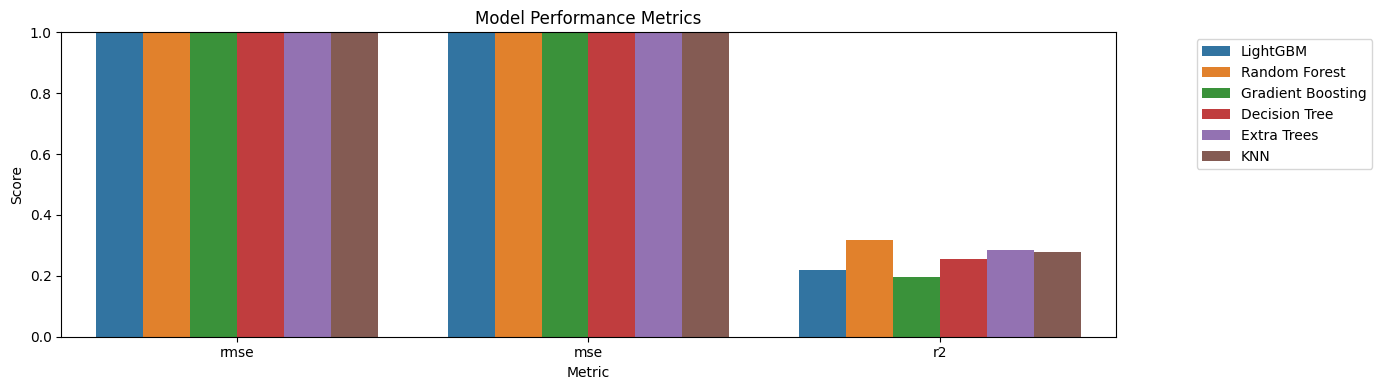

In [36]:

# Define targets
target_sale = 'Sale Price'
target_rental = 'Annual Rental Price'

# Prepare data splits


# X = sales_model_features_df[recommended_features].drop(columns=['Sale Price'])
# y = sales_model_features_df[recommended_features]['Sale Price']

sales_recommended_features_df = sales_model_features_df[sales_recommended_features]

X, X_train_sale, X_val_sale, X_test_sale, y_train_sale, y_val_sale, y_test_sale = prepare_data(
    sales_recommended_features_df,
    target_sale,
    categorical_features=sales_recommended_features_cat_cols,
    numerical_features=sales_recommended_features_num_cols,
)

base_learner = DecisionTreeRegressor(max_depth=1)  # Weak learners are shallow
# model = AdaBoostRegressor(base_estimator=base_learner, n_estimators=50)
regr_2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=50, random_state=42
)

# Define models to be trained
models = {
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42,force_col_wise=True, verbose=-1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    # "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    # "AdaBoost": regr_2,
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
}


# Define the output directory
output_dir = "../models/checkpoints/baseline/sale"

# Execute model training and evaluation for Sale Price prediction
# metrics_df, trained_models, y_pred, feature_importance, X_train_encoded, X_val_encoded

# X, X_train_sale, X_val_sale, X_test_sale, y_train_sale, y_val_sale, y_test_sale

sale_metrics_df, sale_trained_models, sale_y_pred, sale_feature_importances,\
sale_X_train_encoded, sale_X_val_encoded = train_multiple_models(
    X_train=X_train_sale,
    X_val=X_val_sale,
    y_train=y_train_sale,
    y_val=y_val_sale,
    categorical_features=sales_recommended_features_cat_cols,
    numerical_features=sales_recommended_features_num_cols,
    models=models,
    output_dir=output_dir,
    n_estimators=50
)

# Plot feature importance for Sale Price model
# plot_feature_importance(sale_trained_models['Random Forest'], sale_X_train_encoded.columns, "Sale Price")

# Heatmap for Sale Price predictions
# plot_heatmap(y_val_sale, sale_y_pred, "Sale Price")

# Cross-validation results for Sale Price model
# plot_cv_results(sale_trained_models['Random Forest'], sale_X_train_encoded, y_train_sale, "Sale Price")

# Plot learning curve for Sale Price model
# plot_learning_curve(sale_trained_models['Random Forest'], sale_X_train_encoded, y_train_sale, "Sale Price")

# Plot Actual vs Predicted for Sale Price
# plot_actual_vs_predicted(y_val_sale, sale_y_pred, "Sale Price")
    
# Plot residuals for Sale Price
# plot_residuals(y_val_sale, sale_y_pred, "Sale Price")




In [91]:
sale_feature_importances

In [90]:
sale_trained_models

{'LightGBM': LGBMRegressor(force_col_wise=True, learning_rate=0.05, n_estimators=10,
               random_state=42, verbose=-1),
 'Random Forest': RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42),
 'Decision Tree': DecisionTreeRegressor(random_state=42),
 'AdaBoost': AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1), n_estimators=10,
                   random_state=42),
 'Extra Trees': ExtraTreesRegressor(n_estimators=10, random_state=42),
 'KNN': KNeighborsRegressor(n_neighbors=2)}

In [92]:
print('features:', X.columns)

features: Index(['Property Sub Type', 'Number of Rooms', 'Property Size (sq.m)', 'Area',
       'Nearest Metro', 'Nearest Mall', 'Nearest Landmark', 'Usage',
       'Avg Price Last Month', 'Avg Price Last Week'],
      dtype='object')


/var/folders/l6/vts3rj213910_pfyglhvktx00000gn/T/ipykernel_23951/3351011230.py:231: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


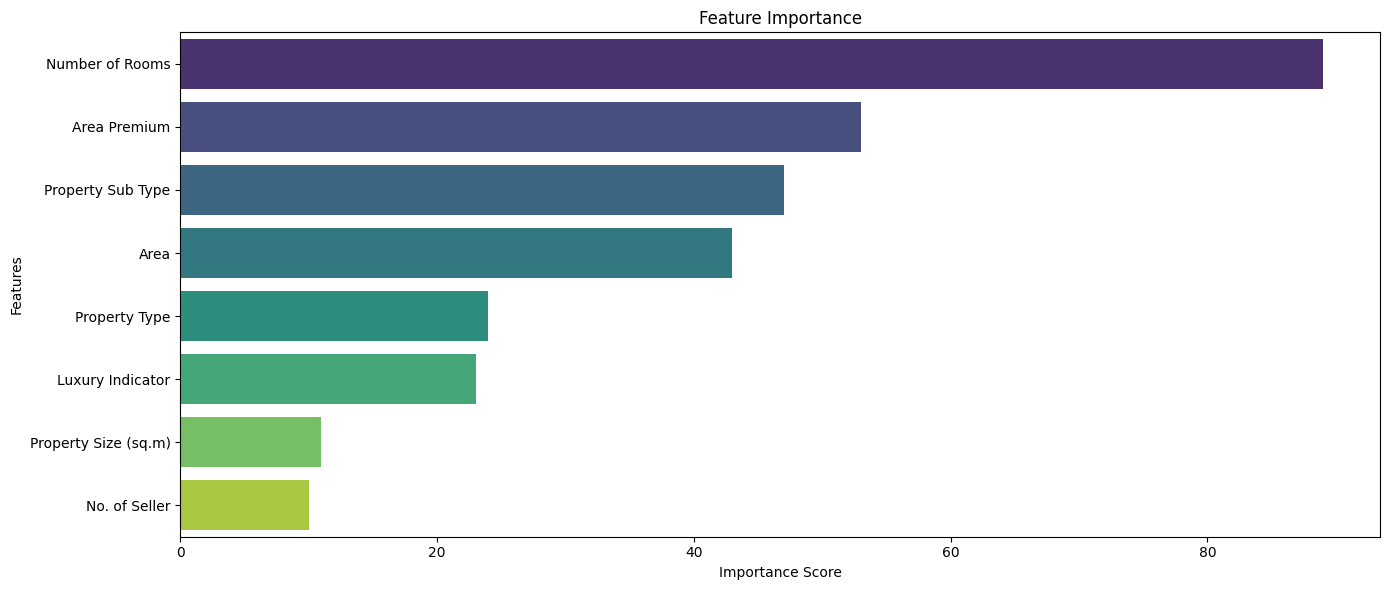

                Feature  Importance
0       Number of Rooms          89
1          Area Premium          53
2     Property Sub Type          47
3                  Area          43
4         Property Type          24
5      Luxury Indicator          23
6  Property Size (sq.m)          11
7         No. of Seller          10


In [ ]:
sale_feature_importances
target = target_sale
model = sale_trained_models['LightGBM']

# Call the function
feature_importances_df = plot_feature_importances(
    model=model,
    feature_names=X.columns,
    top_n=15,  # Optional: Show top 10 features. Remove or set to None to show all features.
    title="Feature Importance"
)

# Display the DataFrame
print(feature_importances_df)


In [ ]:

# feature_names = categorical_features + numerical_features  # Adjust this as necessary to match your feature set
# lightgbm_importances = get_feature_importances(lightgbm_model,feature_names, target)
# lightgbm_importances

In [119]:
sales_recommended_features_df.columns

Index(['Property Sub Type', 'Number of Rooms', 'Property Size (sq.m)', 'Area',
       'Nearest Metro', 'Nearest Mall', 'Nearest Landmark', 'Usage',
       'Avg Price Last Month', 'Avg Price Last Week', 'Sale Price'],
      dtype='object')

In [126]:
rentals_model_features_df.columns

Index(['Parking', 'Property Size (sq.m)', 'Annual Rental Price',
       'Rental Price', 'Is Free Hold?', 'Property Type', 'Nearest Metro',
       'Usage', 'Area', 'Property Sub Type', 'Nearest Mall',
       'Nearest Landmark', 'Ejari Contract Number', 'No of Units', 'Year'],
      dtype='object')

In [ ]:
#     Feature  Importance
# 0  Property Size (sq.m)    0.614342
# 1     Property Sub Type    0.119786
# 2      Nearest Landmark    0.110877
# 3                  Area    0.066566
# 4         Nearest Metro    0.046406
# 5          Nearest Mall    0.021932
# 6         Property Type    0.013375
# 7                 Usage    0.006717


Training LightGBM model...


Training LightGBM: 100%|██████████| 10/10 [00:52<00:00,  5.22s/tree]



LightGBM Model - RMSE: 1808975.83, MSE: 3272393547271.20, R²: 0.00
Model saved to ../models/checkpoints/baseline/rental/LightGBM/LightGBM_model.pkl

Feature Importances for LightGBM:
{'LightGBM': array([101,  22,  75,  51,   9,  34,   8], dtype=int32)}
----------------------------------------------------------------------------------------------------

Training Random Forest model...


Training Random Forest: 100%|██████████| 10/10 [02:17<00:00, 13.74s/tree]



Random Forest Model - RMSE: 1834320.38, MSE: 3364731251636.89, R²: -0.03
Model saved to ../models/checkpoints/baseline/rental/Random Forest/Random Forest_model.pkl

Feature Importances for Random Forest:
{'LightGBM': array([101,  22,  75,  51,   9,  34,   8], dtype=int32), 'Random Forest': array([0.22257952, 0.01464947, 0.48706203, 0.09440643, 0.04543826,
       0.0139341 , 0.12193019])}
----------------------------------------------------------------------------------------------------

Training Gradient Boosting model...


Training Gradient Boosting: 100%|██████████| 10/10 [02:15<00:00, 13.57s/tree]



Gradient Boosting Model - RMSE: 1812912.61, MSE: 3286652133464.56, R²: -0.00
Model saved to ../models/checkpoints/baseline/rental/Gradient Boosting/Gradient Boosting_model.pkl

Feature Importances for Gradient Boosting:
{'LightGBM': array([101,  22,  75,  51,   9,  34,   8], dtype=int32), 'Random Forest': array([0.22257952, 0.01464947, 0.48706203, 0.09440643, 0.04543826,
       0.0139341 , 0.12193019]), 'Gradient Boosting': array([1.38812374e-01, 4.19483327e-02, 7.42183004e-01, 1.69655444e-04,
       5.43128954e-02, 1.89936878e-02, 3.58005005e-03])}
----------------------------------------------------------------------------------------------------

Training Decision Tree model...


Training Decision Tree: 100%|██████████| 10/10 [01:26<00:00,  8.62s/tree]



Decision Tree Model - RMSE: 1858073.82, MSE: 3452438317487.26, R²: -0.05
Model saved to ../models/checkpoints/baseline/rental/Decision Tree/Decision Tree_model.pkl

Feature Importances for Decision Tree:
{'LightGBM': array([101,  22,  75,  51,   9,  34,   8], dtype=int32), 'Random Forest': array([0.22257952, 0.01464947, 0.48706203, 0.09440643, 0.04543826,
       0.0139341 , 0.12193019]), 'Gradient Boosting': array([1.38812374e-01, 4.19483327e-02, 7.42183004e-01, 1.69655444e-04,
       5.43128954e-02, 1.89936878e-02, 3.58005005e-03]), 'Decision Tree': array([0.14921714, 0.01849202, 0.58588733, 0.04267178, 0.06138112,
       0.01603582, 0.12631479])}
----------------------------------------------------------------------------------------------------

Training Extra Trees model...


Training Extra Trees: 100%|██████████| 10/10 [03:33<00:00, 21.40s/tree]



Extra Trees Model - RMSE: 1811766.46, MSE: 3282497690382.23, R²: -0.00
Model saved to ../models/checkpoints/baseline/rental/Extra Trees/Extra Trees_model.pkl

Feature Importances for Extra Trees:
{'LightGBM': array([101,  22,  75,  51,   9,  34,   8], dtype=int32), 'Random Forest': array([0.22257952, 0.01464947, 0.48706203, 0.09440643, 0.04543826,
       0.0139341 , 0.12193019]), 'Gradient Boosting': array([1.38812374e-01, 4.19483327e-02, 7.42183004e-01, 1.69655444e-04,
       5.43128954e-02, 1.89936878e-02, 3.58005005e-03]), 'Decision Tree': array([0.14921714, 0.01849202, 0.58588733, 0.04267178, 0.06138112,
       0.01603582, 0.12631479]), 'Extra Trees': array([0.23248755, 0.03195526, 0.44474227, 0.09147797, 0.06645144,
       0.07744835, 0.05543716])}
----------------------------------------------------------------------------------------------------

Training KNN model...


Training KNN: 100%|██████████| 10/10 [01:13<00:00,  7.36s/tree]



KNN Model - RMSE: 1804013.29, MSE: 3254463945729.05, R²: 0.01
Model saved to ../models/checkpoints/baseline/rental/KNN/KNN_model.pkl
----------------------------------------------------------------------------------------------------


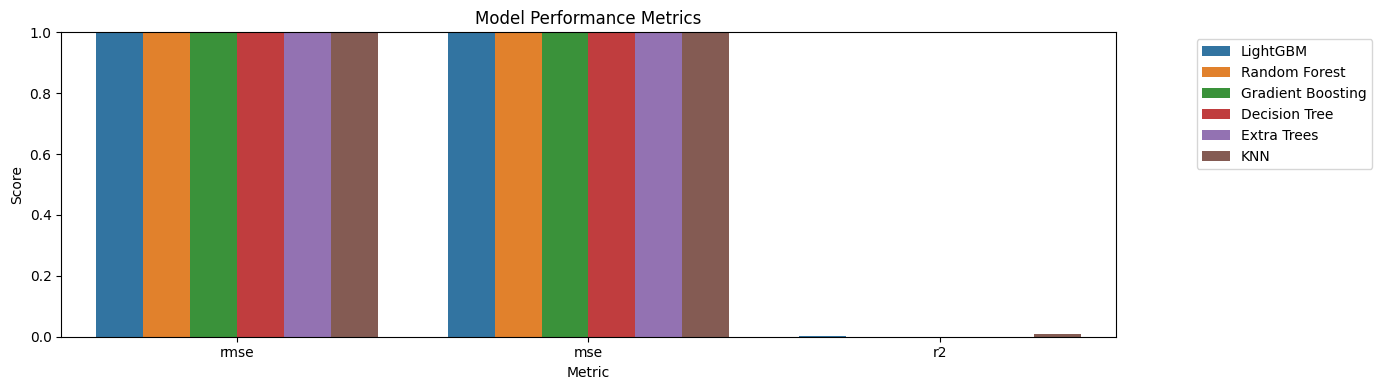

In [37]:

output_dir = "../models/checkpoints/baseline/rental"

rentals_recommended_features = [
    'Property Sub Type',  # or 'Property Type'
    'Property Type',
    # 'Number of Rooms',    # or 'Room(s)', replaced
    'Property Size (sq.m)',
    'Area',
    'Nearest Metro',
    'Nearest Mall',
    'Nearest Landmark',
    # 'No of Units', 
    # 'Year',
    'Usage',
    # 'Parking',
    # 'Is Free Hold?',
    # 'Avg Price Last Month', # replaced
    # 'Avg Price Last Week', # replaced
    'Annual Rental Price'
]

models = {
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42,force_col_wise=True, verbose=-1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    # "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    # "AdaBoost": regr_2,
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
}


rentals_recommended_features_cat_cols = rentals_model_features_df[rentals_recommended_features].select_dtypes(exclude=['number']).columns
rentals_recommended_features_num_cols = rentals_model_features_df[rentals_recommended_features].select_dtypes(include=['number']).columns


rentals_recommended_features_df = rentals_model_features_df[rentals_recommended_features]

X, X_train_rentals, X_val_rentals, X_test_rentals, y_train_rentals, y_val_rentals, y_test_rentals = prepare_data(
    rentals_recommended_features_df,
    target_rental,
    categorical_features=rentals_recommended_features_cat_cols,
    numerical_features=rentals_recommended_features_num_cols,
)

# Execute model training and evaluation for Rental Price prediction
rental_metrics_df, rental_trained_models, rental_y_pred, rental_feature_importances,\
rental_X_train_encoded, rental_X_val_encoded = train_multiple_models(
    X_train=X_train_rentals,
    X_val=X_val_rentals,
    y_train=y_train_rentals,
    y_val=y_val_rentals,
    categorical_features=rentals_recommended_features_cat_cols,
    numerical_features=rentals_recommended_features_num_cols,
    models=models,
    output_dir=output_dir,
    n_estimators=10
)

# Heatmap for Rental Price predictions
# plot_heatmap(y_val_rental, rental_y_pred, "Annual Rental Price")

# Cross-validation results for Rental Price model
# plot_cv_results(rental_trained_models['Random Forest'], rental_X_train_encoded, y_train_rental, "Rental Price")

# Plot learning curve for Sale Price model
# plot_learning_curve(rental_trained_models['Random Forest'], sale_X_train_encoded, y_train_sale, "Sale Price")

# Plot feature importance for Rental Price model
# plot_feature_importance(rental_trained_models['Random Forest'], rental_X_train_encoded.columns, "Rental Price")

# Plot Actual vs Predicted for Rental Price
# plot_actual_vs_predicted(y_val_rental, rental_y_pred, "Annual Rental Price")

# Plot residuals for Rental Price
# plot_residuals(y_val_rental, rental_y_pred, "Annual Rental Price")

In [141]:
rental_metrics_df

,Model,rmse,mse,r2
0,Decision Tree,2.515685e+06,6.328672e+12,-0.820956


In [140]:
rental_feature_importances

{'Decision Tree': array([0.01231059, 0.52686933, 0.00880851, 0.00382545, 0.00263274,
        0.44140985, 0.00414353])}

/var/folders/l6/vts3rj213910_pfyglhvktx00000gn/T/ipykernel_23951/3351011230.py:231: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


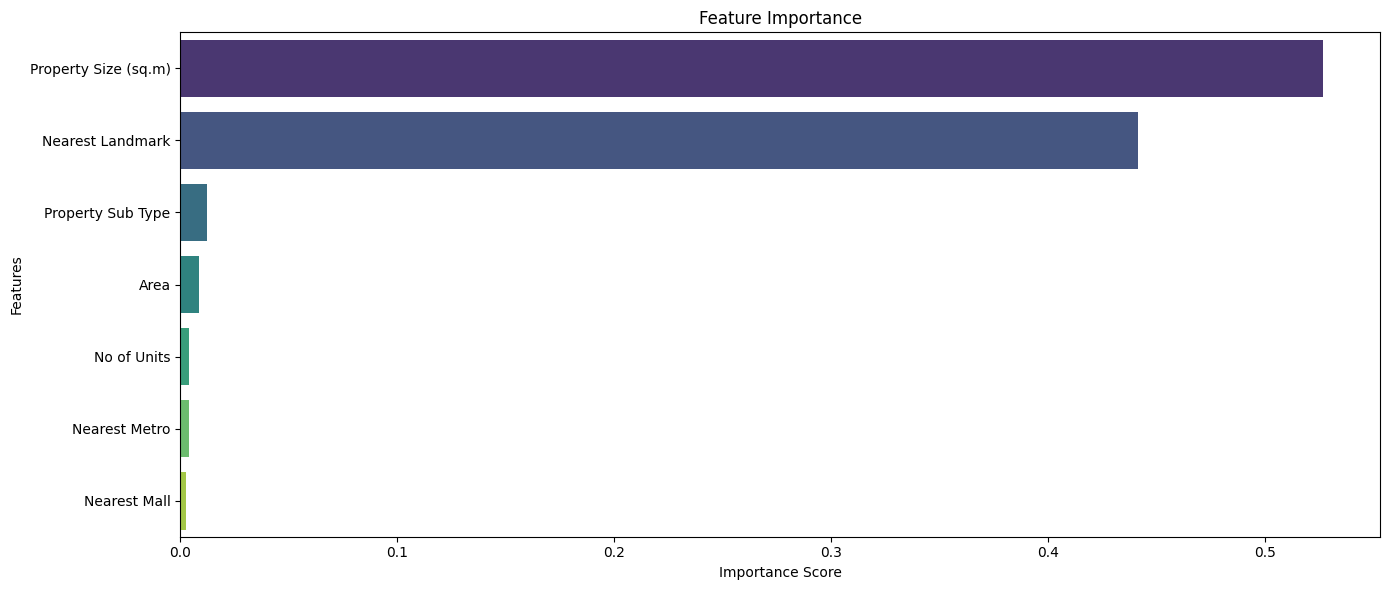

                Feature  Importance
0  Property Size (sq.m)    0.526869
1      Nearest Landmark    0.441410
2     Property Sub Type    0.012311
3                  Area    0.008809
4           No of Units    0.004144
5         Nearest Metro    0.003825
6          Nearest Mall    0.002633


In [143]:

target = target_rental
model = rental_trained_models['Decision Tree']

# Call the function
feature_importances_df = plot_feature_importances(
    model=model,
    feature_names=X.columns,
    top_n=15,  # Optional: Show top 10 features. Remove or set to None to show all features.
    title="Feature Importance"
)

# Display the DataFrame
print(feature_importances_df)

- Tuning Function

In [179]:
def train_and_tune_models(
    X_train, X_val, y_train, y_val, categorical_features, numerical_features, models, tuning="grid",model_group=None, scoring=None, early_stopping=True, cv=3, output_dir="../models/checkpoints/tuned"
):
    """
    Trains multiple models with hyperparameter tuning (Grid Search, Randomized Search, or Bayesian) and optional early stopping.

    Args:
        X_train (DataFrame): Training features.
        X_val (DataFrame): Validation features.
        y_train (Series): Training target.
        y_val (Series): Validation target.
        categorical_features (list): Categorical feature names.
        numerical_features (list): Numerical feature names.
        models (dict): Dictionary of models with default hyperparameters.
        tuning (str): 'grid', 'random', or 'bayesian' for hyperparameter tuning.
        early_stopping (bool): Whether to apply early stopping for applicable models.
        output_dir (str): Directory to save trained models.

    Returns:
        metrics_df (DataFrame): Model evaluation metrics.
        tuned_models (dict): Dictionary of trained models with best hyperparameters.
    """

    
        # Ordinal Encoding for categorical features
    
    os.makedirs(output_dir, exist_ok=True)

    # Define preprocessing pipelines
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    preprocessor = Pipeline(steps=[
        ('num', numerical_transformer),
        ('cat', categorical_transformer)
    ])

    # Metrics storage
    metrics = []
    tuned_models = {}

    # Tuning configurations for each model
 
    random_param_grids = {
    "LightGBM": {
        "regressor__n_estimators": randint(20, 100),  # Fewer estimators
        "regressor__learning_rate": uniform(0.05, 0.1),  # Narrow learning rate
        "regressor__max_depth": randint(3, 10),  # Shallower trees
        "regressor__num_leaves": randint(15, 31),  # Simplify trees
    },
    "RandomForest": {
        "regressor__n_estimators": randint(20, 100),  # Fewer estimators
        "regressor__max_depth": randint(3, 10),  # Limit tree depth
        "regressor__min_samples_split": randint(5, 15),  # Fewer splits
        "regressor__min_samples_leaf": randint(5, 10),
    },
    "XGBoost": {
        "regressor__n_estimators": randint(20, 100),  # Fewer estimators
        "regressor__learning_rate": uniform(0.05, 0.1),  # Narrow range
        "regressor__max_depth": randint(3, 6),  # Shallower trees
        "regressor__gamma": uniform(0, 0.1),  # Regularization
        "regressor__subsample": uniform(0.7, 0.3),  # Smaller subsample
    },
    "GradientBoosting": {
        "regressor__n_estimators": randint(20, 100),  # Fewer estimators
        "regressor__learning_rate": uniform(0.05, 0.1),  # Narrow range
        "regressor__max_depth": randint(3, 6),  # Shallower trees
        "regressor__subsample": uniform(0.7, 0.3),  # Smaller subsample
    },
    "AdaBoost": {
        "regressor__n_estimators": randint(20, 50),  # Fewer iterations
        "regressor__learning_rate": uniform(0.05, 0.1),  # Narrow range
        "regressor__loss": ["linear", "square"],  # Fewer options
    },
    "SVR": {
        "regressor__C": uniform(0.1, 5),  # Smaller range
        "regressor__epsilon": uniform(0.05, 0.2),  # Narrow range
        "regressor__kernel": ["linear", "rbf"],  # Simpler kernels
    },
    "KNN": {
        "regressor__n_neighbors": randint(3, 10),  # Smaller range
        "regressor__weights": ["uniform", "distance"],
        "regressor__metric": ["minkowski", "euclidean"],
    },
    "LinearRegression": {
        "regressor__fit_intercept": [True, False],
        "regressor__normalize": [True, False],
    },
    "ExtraTrees": {
        "regressor__n_estimators": randint(20, 100),  # Fewer estimators
        "regressor__max_depth": randint(3, 10),  # Shallower trees
        "regressor__min_samples_split": randint(5, 15),
        "regressor__min_samples_leaf": randint(5, 10),
    },
    "DecisionTree": {
        "regressor__max_depth": randint(3, 10),  # Shallower trees
        "regressor__min_samples_split": randint(5, 15),
        "regressor__min_samples_leaf": randint(5, 10),
    },
}
  
    grid_param_grids = {
    "LightGBM": {
        "regressor__n_estimators": [20, 50, 100],  # Fewer estimators
        "regressor__learning_rate": [0.05, 0.1],  # Narrow range
        "regressor__max_depth": [3, 5, 10],  # Shallower trees
        "regressor__num_leaves": [15, 31],
    },
    "RandomForest": {
        "regressor__n_estimators": [20, 50, 100],  # Fewer estimators
        "regressor__max_depth": [3, 5, 10],
        "regressor__min_samples_split": [5, 10],
        "regressor__min_samples_leaf": [5, 10],
    },
    "XGBoost": {
        "regressor__n_estimators": [20, 50, 100],  # Fewer estimators
        "regressor__learning_rate": [0.05, 0.1],
        "regressor__max_depth": [3, 5],
        "regressor__gamma": [0, 0.1],
        "regressor__subsample": [0.7, 1.0],
    },
    "GradientBoosting": {
        "regressor__n_estimators": [20, 50, 100],
        "regressor__learning_rate": [0.05, 0.1],
        "regressor__max_depth": [3, 5],
        "regressor__subsample": [0.7, 1.0],
    },
    "AdaBoost": {
        "regressor__n_estimators": [20, 50],
        "regressor__learning_rate": [0.05, 0.1],
        "regressor__loss": ["linear", "square"],
    },
    "SVR": {
        "regressor__C": [0.1, 1, 5],
        "regressor__epsilon": [0.05, 0.1],
        "regressor__kernel": ["linear", "rbf"],
    },
    "KNN": {
        "regressor__n_neighbors": [3, 5],
        "regressor__weights": ["uniform", "distance"],
        "regressor__metric": ["minkowski", "euclidean"],
    },
    "LinearRegression": {
        "regressor__fit_intercept": [True, False],
        "regressor__normalize": [True, False],
    },
    "ExtraTrees": {
        "regressor__n_estimators": [20, 50, 100],
        "regressor__max_depth": [3, 5, 10],
        "regressor__min_samples_split": [5, 10],
        "regressor__min_samples_leaf": [5, 10],
    },
    "DecisionTree": {
        "regressor__max_depth": [3, 5, 10],
        "regressor__min_samples_split": [5, 10],
        "regressor__min_samples_leaf": [5, 10],
    },
}

    bayesian_param_spaces = {
    "LightGBM": {
        "n_estimators": lambda trial: trial.suggest_int("n_estimators", 50, 200),
        "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 20),
        "num_leaves": lambda trial: trial.suggest_int("num_leaves", 15, 63),
    },
    "RandomForest": {
        "n_estimators": lambda trial: trial.suggest_int("n_estimators", 50, 200),
        "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": lambda trial: trial.suggest_int("min_samples_split", 2, 15),
        "min_samples_leaf": lambda trial: trial.suggest_int("min_samples_leaf", 1, 10),
    },
    # Add other models here if needed
   }

    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_encoded = encoder.fit_transform(X_train[categorical_features])
    X_val_encoded = encoder.transform(X_val[categorical_features])
    
    print(f"Model 1: Estimating property {model_group} prices using real estate transaction data only.")
    # Loop over models
    for model_name, model in models.items():
        print(f"\nTraining and tuning {model_name} model with {cv}-fold cross-validators...")
        model_output_dir = os.path.join(output_dir, model_name)
        os.makedirs(model_output_dir, exist_ok=True)

        # Set up the pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Apply n_estimators only for tree-based and ensemble models
        if model_name in ["Random Forest", "Gradient Boosting", "XGBoost", "LightGBM", "AdaBoost", "Extra Trees"]:
            model.set_params(n_estimators=cv) # Incrementally add trees

        # Progress bar for model training
        progress_bar = tqdm(range(1, cv + 1), desc=f"Training {model_name}", unit="tree")

        for i in progress_bar:
            
            # Select tuning method
            # param_grid = param_grids.get(model_name, {})
            if tuning == "grid":
                param_grid = grid_param_grids.get(model_name, {})
                print(f"Performing Grid Search for {model_name} and {tuning} tuning...")
                tuner = GridSearchCV(
                    pipeline, param_grid, scoring=scoring, n_jobs=-1, cv=cv, verbose=0
                )
            elif tuning == "random":
                param_grid = random_param_grids.get(model_name, {})
                print(f"Performing Randomized Search for {model_name} and {tuning} tuning...")
                tuner = RandomizedSearchCV(
                    pipeline, param_grid, n_iter=30, cv=cv, scoring=scoring, n_jobs=-1, verbose=0, random_state=42
                )
                
            elif tuning == "bayesian" and model_name in bayesian_param_spaces:
                print(f"Performing Bayesian Search for {model_name}...")
                optuna.logging.set_verbosity(optuna.logging.WARNING)
                param_space = bayesian_param_spaces[model_name]
                
                def objective(trial):
                    # Set parameters from the defined space
                    params = {f"regressor__{key}": func(trial) for key, func in param_space.items()}
                    
                    pipeline.set_params(**params)
                    
                    pipeline.fit(X_train_encoded, y_train)
                    y_pred = pipeline.predict(X_val_encoded)
                    return mean_squared_error(y_val, y_pred)
                
                study = optuna.create_study(direction="minimize")
                study.optimize(objective, n_trials=20, timeout=3600)
                best_params = study.best_params
                
                 # Update the pipeline with best parameters
                pipeline.set_params(**best_params)
                best_model = pipeline.fit(X_train_encoded, y_train)
                best_score = -study.best_value
                # tuner = pipeline  # No tuner for Bayesian; model is trained directly
                
            else:
                print(f"No tuning for {model_name}. Skipping...")
                continue

            # Perform hyperparameter tuning
            if tuning != "bayesian":
                tuner.fit(X_train_encoded, y_train)
                best_model = tuner.best_estimator_
                best_params = tuner.best_params_
                best_score =  tuner.best_score_
            # else:
                # best_model = tuner  # For Bayesian, model is already tuned
                # best_params = study.best_params if tuning == "bayesian" else {}
                # best_score = study.best_score if tuning == "bayesian" else {}

        # Save the trained model
        model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
        joblib.dump(best_model, model_path)
        print(f"Best {model_name} saved at {model_path}.")
        
        # Evaluate the model
        y_pred = best_model.predict(X_val_encoded)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
                # Cross-validation scores
        # cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring=scoring)
        
        # store tuned models
        # tuned_models[model_name] = best_model
        
        metrics.append({
            "Model": model_name,
            "RMSE": rmse,
            "MSE": mse,
            "RSquared": r2,
            # "Best Params": str(best_params),
            "Best Params": best_params,
            "Best Score": best_score,
            # 'CV Accuracy': cv_scores.mean()
        })
                
        # print(f"\n{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f}")
        print(f"Best parameters for {model_name}: {best_params}")
        print(f"Best {scoring} score: {best_score:.4f}\n")
        
        print("-"*120)

    # Visualize metrics
    metrics_df = pd.DataFrame(metrics)
    
    print("Performance metrics:")
    print(metrics_df)
    print("-"*120)
    
    metrics_df.set_index('Model')[['RMSE', 'MSE', 'RSquared']].plot(kind='bar', figsize=(14, 4))
    plt.ylabel('Scores')
    plt.title('Model Performance Comparison')
    plt.show()


    return metrics_df, tuned_models


In [119]:
# def train_and_tune_models(
#     X_train, X_val, y_train, y_val, categorical_features, numerical_features, models, tuning="grid", early_stopping=True, cv=3, output_dir="../models/checkpoints/tuned"
# ):
#     """
#     Trains multiple models with hyperparameter tuning (Grid Search, Randomized Search, or Bayesian) and optional early stopping.

#     Args:
#         X_train (DataFrame): Training features.
#         X_val (DataFrame): Validation features.
#         y_train (Series): Training target.
#         y_val (Series): Validation target.
#         categorical_features (list): Categorical feature names.
#         numerical_features (list): Numerical feature names.
#         models (dict): Dictionary of models with default hyperparameters.
#         tuning (str): 'grid', 'random', or 'bayesian' for hyperparameter tuning.
#         early_stopping (bool): Whether to apply early stopping for applicable models.
#         cv (int): Number of cross-validation splits.
#         output_dir (str): Directory to save trained models.

#     Returns:
#         metrics_df (DataFrame): Model evaluation metrics.
#         tuned_models (dict): Dictionary of trained models with best hyperparameters.
#     """

#     os.makedirs(output_dir, exist_ok=True)

#     # Define preprocessing pipelines
#     numerical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='mean')),
#         ('scaler', StandardScaler())
#     ])

#     categorical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
#     ])

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numerical_transformer, numerical_features),
#             ('cat', categorical_transformer, categorical_features)
#         ]
#     )

#     # Metrics storage
#     metrics = []
#     tuned_models = {}

#     # Define parameter grids
#     grid_param_grids = {
#         "LightGBM": {
#             "regressor__n_estimators": [50, 100, 150],
#             "regressor__learning_rate": [0.01, 0.05, 0.1],
#             "regressor__max_depth": [3, 5, 10],
#         },
#     }
#     random_param_grids = {
#         "LightGBM": {
#             "regressor__n_estimators": randint(50, 200),
#             "regressor__learning_rate": uniform(0.01, 0.2),
#             "regressor__max_depth": randint(3, 20),
#         },
#     }

#     # Loop over models
#     for model_name, model in models.items():
#         print(f"\nTraining and tuning {model_name} model with {cv}-fold cross-validation...")
#         model_output_dir = os.path.join(output_dir, model_name)
#         os.makedirs(model_output_dir, exist_ok=True)

#         # Set up the pipeline
#         pipeline = Pipeline(steps=[
#             ('preprocessor', preprocessor),
#             ('regressor', model)
#         ])

#         # Select parameter grid
#         if tuning == "grid":
#             param_grid = grid_param_grids.get(model_name, {})
#             tuner = GridSearchCV(
#                 pipeline, param_grid, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2
#             )
#         elif tuning == "random":
#             param_grid = random_param_grids.get(model_name, {})
#             tuner = RandomizedSearchCV(
#                 pipeline, param_grid, n_iter=20, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2, random_state=42
#             )
#         elif tuning == "bayesian" and model_name == "LightGBM":
#             def objective(trial):
#                 params = {
#                     "regressor__n_estimators": trial.suggest_int("n_estimators", 50, 200),
#                     "regressor__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
#                     "regressor__max_depth": trial.suggest_int("max_depth", 3, 20),
#                 }
#                 pipeline.set_params(**params)
#                 pipeline.fit(X_train, y_train)
#                 y_pred = pipeline.predict(X_val)
#                 return mean_squared_error(y_val, y_pred)

#             study = optuna.create_study(direction="minimize")
#             study.optimize(objective, n_trials=20)
#             best_params = study.best_params
#             pipeline.set_params(**best_params)
#             pipeline.fit(X_train, y_train)
#             best_model = pipeline
#         else:
#             print(f"No tuning for {model_name}. Skipping...")
#             continue

#         # Perform hyperparameter tuning
#         if tuning != "bayesian":
#             tuner.fit(X_train, y_train)
#             best_model = tuner.best_estimator_
#             best_params = tuner.best_params_
#         else:
#             best_params = study.best_params if tuning == "bayesian" else {}

#         # Save the trained model
#         model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
#         joblib.dump(best_model, model_path)
#         print(f"Best {model_name} saved at {model_path}.")

#         # Evaluate the model
#         y_pred = best_model.predict(X_val)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         mse = mean_squared_error(y_val, y_pred)
#         r2 = r2_score(y_val, y_pred)

#         metrics.append({
#             "Model": model_name,
#             "RMSE": rmse,
#             "MSE": mse,
#             "R²": r2,
#             "Best Params": best_params,
#         })

#         tuned_models[model_name] = best_model

#     # Visualize metrics
#     metrics_df = pd.DataFrame(metrics)
#     plt.figure(figsize=(14, 4))
#     sns.barplot(data=metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), x="Metric", y="Score", hue="Model")
#     plt.title("Model Performance Metrics")
#     plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
#     plt.tight_layout()
#     plt.show()

#     return metrics_df, tuned_models

# 1. **Model 1**: Estimating property sale prices using **real estate transaction data** only.
# 2. **Model 2**: Estimating property rental prices using **real estate transaction data** only.
# 3. **Model 3**: Estimating property sale prices incorporating **both real estate and supplementary data**.
# 4. **Model 4**: Estimating property rental prices incorporating **both real estate and supplementary data**.

- model for all

In [190]:
models = {
 "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42, verbose=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42)
}

- tuned grid sale 

Model 1: Estimating property sale prices using real estate transaction data only.

Training and tuning Random Forest model with 3-fold cross-validators...


Training Random Forest:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Random Forest and grid tuning...


Training Random Forest:  33%|███▎      | 1/3 [00:10<00:21, 10.77s/tree]

Performing Grid Search for Random Forest and grid tuning...


Training Random Forest:  67%|██████▋   | 2/3 [00:18<00:08,  8.72s/tree]

Performing Grid Search for Random Forest and grid tuning...


Training Random Forest: 100%|██████████| 3/3 [00:24<00:00,  8.32s/tree]


Best Random Forest saved at ../models/checkpoints/tuned/grid/sale/Random Forest/Random Forest_model.pkl.
Best parameters for Random Forest: {}
Best neg_mean_squared_error score: -2666365509039178.0000

------------------------------------------------------------------------------------------------------------------------

Training and tuning LightGBM model with 3-fold cross-validators...


Training LightGBM:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for LightGBM and grid tuning...


Training LightGBM:  33%|███▎      | 1/3 [04:34<09:08, 274.19s/tree]

Performing Grid Search for LightGBM and grid tuning...


Training LightGBM:  67%|██████▋   | 2/3 [08:49<04:22, 262.96s/tree]

Performing Grid Search for LightGBM and grid tuning...


Training LightGBM: 100%|██████████| 3/3 [12:56<00:00, 258.71s/tree]


Best LightGBM saved at ../models/checkpoints/tuned/grid/sale/LightGBM/LightGBM_model.pkl.
Best parameters for LightGBM: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 150, 'regressor__num_leaves': 63}
Best neg_mean_squared_error score: -2124625615026185.0000

------------------------------------------------------------------------------------------------------------------------

Training and tuning Gradient Boosting model with 3-fold cross-validators...


Training Gradient Boosting:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Gradient Boosting and grid tuning...


Training Gradient Boosting:  33%|███▎      | 1/3 [00:04<00:09,  4.87s/tree]

Performing Grid Search for Gradient Boosting and grid tuning...


Training Gradient Boosting:  67%|██████▋   | 2/3 [00:09<00:04,  4.85s/tree]

Performing Grid Search for Gradient Boosting and grid tuning...


Training Gradient Boosting: 100%|██████████| 3/3 [00:14<00:00,  4.85s/tree]


Best Gradient Boosting saved at ../models/checkpoints/tuned/grid/sale/Gradient Boosting/Gradient Boosting_model.pkl.
Best parameters for Gradient Boosting: {}
Best neg_mean_squared_error score: -2434940437381478.5000

------------------------------------------------------------------------------------------------------------------------

Training and tuning KNN model with 3-fold cross-validators...


Training KNN:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for KNN and grid tuning...


Training KNN:  33%|███▎      | 1/3 [01:10<02:21, 70.51s/tree]

Performing Grid Search for KNN and grid tuning...


Training KNN:  67%|██████▋   | 2/3 [02:20<01:10, 70.31s/tree]

Performing Grid Search for KNN and grid tuning...


Training KNN: 100%|██████████| 3/3 [03:31<00:00, 70.39s/tree]


Best KNN saved at ../models/checkpoints/tuned/grid/sale/KNN/KNN_model.pkl.
Best parameters for KNN: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 5, 'regressor__weights': 'distance'}
Best neg_mean_squared_error score: -2035063537063978.2500

------------------------------------------------------------------------------------------------------------------------

Training and tuning Linear Regression model with 3-fold cross-validators...


Training Linear Regression:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Linear Regression and grid tuning...


Training Linear Regression:  33%|███▎      | 1/3 [00:02<00:05,  2.74s/tree]

Performing Grid Search for Linear Regression and grid tuning...


Training Linear Regression:  67%|██████▋   | 2/3 [00:05<00:02,  2.55s/tree]

Performing Grid Search for Linear Regression and grid tuning...


Training Linear Regression: 100%|██████████| 3/3 [00:07<00:00,  2.60s/tree]


Best Linear Regression saved at ../models/checkpoints/tuned/grid/sale/Linear Regression/Linear Regression_model.pkl.
Best parameters for Linear Regression: {}
Best neg_mean_squared_error score: -2431679259063111.5000

------------------------------------------------------------------------------------------------------------------------

Training and tuning Decision Tree model with 3-fold cross-validators...


Training Decision Tree:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Decision Tree and grid tuning...


Training Decision Tree:  33%|███▎      | 1/3 [00:05<00:10,  5.46s/tree]

Performing Grid Search for Decision Tree and grid tuning...


Training Decision Tree:  67%|██████▋   | 2/3 [00:11<00:05,  5.55s/tree]

Performing Grid Search for Decision Tree and grid tuning...


Training Decision Tree: 100%|██████████| 3/3 [00:16<00:00,  5.56s/tree]


Best Decision Tree saved at ../models/checkpoints/tuned/grid/sale/Decision Tree/Decision Tree_model.pkl.
Best parameters for Decision Tree: {}
Best neg_mean_squared_error score: -3748792601460463.5000

------------------------------------------------------------------------------------------------------------------------

Training and tuning AdaBoost model with 3-fold cross-validators...


Training AdaBoost:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for AdaBoost and grid tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Training AdaBoost:  33%|███▎      | 1/3 [18:24<36:49, 1104.65s/tree]

Performing Grid Search for AdaBoost and grid tuning...


Training AdaBoost:  67%|██████▋   | 2/3 [36:42<18:20, 1100.83s/tree]

Performing Grid Search for AdaBoost and grid tuning...


Training AdaBoost: 100%|██████████| 3/3 [54:36<00:00, 1092.15s/tree]


Best AdaBoost saved at ../models/checkpoints/tuned/grid/sale/AdaBoost/AdaBoost_model.pkl.
Best parameters for AdaBoost: {'regressor__learning_rate': 0.01, 'regressor__loss': 'exponential', 'regressor__n_estimators': 50}
Best neg_mean_squared_error score: -2412564840339160.0000

------------------------------------------------------------------------------------------------------------------------

Training and tuning Extra Trees model with 3-fold cross-validators...


Training Extra Trees:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Extra Trees and grid tuning...


Training Extra Trees:  33%|███▎      | 1/3 [00:06<00:12,  6.31s/tree]

Performing Grid Search for Extra Trees and grid tuning...


Training Extra Trees:  67%|██████▋   | 2/3 [00:12<00:06,  6.41s/tree]

Performing Grid Search for Extra Trees and grid tuning...


Training Extra Trees: 100%|██████████| 3/3 [00:19<00:00,  6.47s/tree]


Best Extra Trees saved at ../models/checkpoints/tuned/grid/sale/Extra Trees/Extra Trees_model.pkl.
Best parameters for Extra Trees: {}
Best neg_mean_squared_error score: -2608328837278753.5000

------------------------------------------------------------------------------------------------------------------------
Performance metrics:
               Model          RMSE           MSE  RSquared  \
0      Random Forest  4.769604e+07  2.274912e+15 -0.379189   
1           LightGBM  3.629073e+07  1.317017e+15  0.201545   
2  Gradient Boosting  4.033076e+07  1.626570e+15  0.013875   
3                KNN  3.262510e+07  1.064397e+15  0.354698   
4  Linear Regression  4.030592e+07  1.624567e+15  0.015089   
5      Decision Tree  5.830761e+07  3.399777e+15 -1.061150   
6           AdaBoost  4.019283e+07  1.615463e+15  0.020609   
7        Extra Trees  3.956086e+07  1.565061e+15  0.051165   

                                         Best Params    Best Score  
0                                   

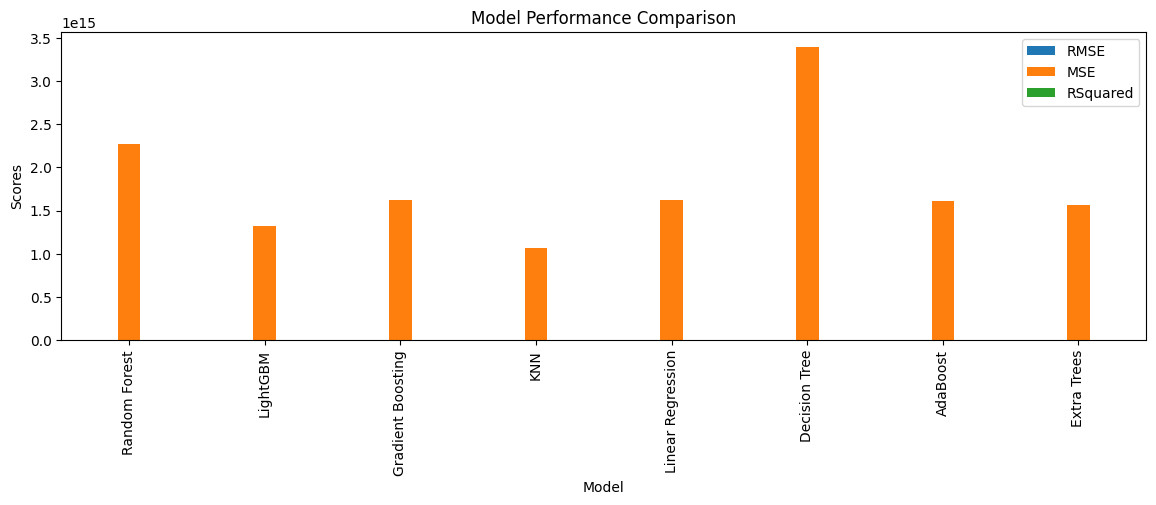

In [ ]:
output_dir = "../models/checkpoints/tuned/grid/sale"
model_group = 'sale'


grid_tuned_sale_metrics_df, grid_tuned_sale_models = train_and_tune_models(
    X_train=X_train,
    X_val=X_val,
    y_train=y_train,
    y_val=y_val,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    models=models,
    tuning="grid",  # Choose "grid", "random", or "bayesian"
    model_group=model_group,
    scoring="neg_mean_squared_error",
    early_stopping=True,
    cv=3,
    output_dir=output_dir
)

In [171]:
sales_model_features_df['Property Sub Type'].unique()

['Residential', 'Commercial', 'Flat', 'Villa', 'Hotel Apartment', ..., 'Mosque', 'Multi Store Parcking', 'Embassy', 'Commercial / Offices / Residential', 'Store']
Length: 47
Categories (47, object): ['Agricultural', 'Airport', 'Building', 'Car Services', ..., 'Unit', 'Villa', 'Warehouse', 'Workshop']

- tuned randomized sale

Model 1: Estimating property sale prices using real estate transaction data only.

Training and tuning Random Forest model with 3-fold cross-validators...


Training Random Forest:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Random Forest and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Random Forest:  33%|███▎      | 1/3 [00:06<00:12,  6.01s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Random Forest and random tuning...


Training Random Forest:  67%|██████▋   | 2/3 [00:11<00:05,  5.96s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Random Forest and random tuning...


Training Random Forest: 100%|██████████| 3/3 [00:17<00:00,  5.94s/tree]


Best Random Forest saved at ../models/checkpoints/tuned/random/sale/Random Forest/Random Forest_model.pkl.
Best parameters for Random Forest: {}
Best neg_mean_squared_error score: -2666365509039178.0000

------------------------------------------------------------------------------------------------------------------------

Training and tuning LightGBM model with 3-fold cross-validators...


Training LightGBM:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for LightGBM and random tuning...


Training LightGBM:  33%|███▎      | 1/3 [02:11<04:23, 131.96s/tree]

Performing Randomized Search for LightGBM and random tuning...


Training LightGBM:  67%|██████▋   | 2/3 [04:23<02:11, 131.89s/tree]

Performing Randomized Search for LightGBM and random tuning...


Training LightGBM: 100%|██████████| 3/3 [06:36<00:00, 132.15s/tree]


Best LightGBM saved at ../models/checkpoints/tuned/random/sale/LightGBM/LightGBM_model.pkl.
Best parameters for LightGBM: {'regressor__learning_rate': 0.13349630192554332, 'regressor__max_depth': 14, 'regressor__n_estimators': 138, 'regressor__num_leaves': 41}
Best neg_mean_squared_error score: -2116914253377302.0000

------------------------------------------------------------------------------------------------------------------------

Training and tuning Gradient Boosting model with 3-fold cross-validators...


Training Gradient Boosting:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Gradient Boosting and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Gradient Boosting:  33%|███▎      | 1/3 [00:04<00:09,  4.75s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Gradient Boosting and random tuning...


Training Gradient Boosting:  67%|██████▋   | 2/3 [00:09<00:04,  4.73s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Gradient Boosting and random tuning...


Training Gradient Boosting: 100%|██████████| 3/3 [00:14<00:00,  4.85s/tree]


Best Gradient Boosting saved at ../models/checkpoints/tuned/random/sale/Gradient Boosting/Gradient Boosting_model.pkl.
Best parameters for Gradient Boosting: {}
Best neg_mean_squared_error score: -2434940437381478.5000

------------------------------------------------------------------------------------------------------------------------

Training and tuning KNN model with 3-fold cross-validators...


Training KNN:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for KNN and random tuning...


Training KNN:  33%|███▎      | 1/3 [02:12<04:25, 132.89s/tree]

Performing Randomized Search for KNN and random tuning...


Training KNN:  67%|██████▋   | 2/3 [04:24<02:12, 132.28s/tree]

Performing Randomized Search for KNN and random tuning...


Training KNN: 100%|██████████| 3/3 [06:37<00:00, 132.57s/tree]


Best KNN saved at ../models/checkpoints/tuned/random/sale/KNN/KNN_model.pkl.
Best parameters for KNN: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 4, 'regressor__weights': 'distance'}
Best neg_mean_squared_error score: -2028851846656371.0000

------------------------------------------------------------------------------------------------------------------------

Training and tuning Linear Regression model with 3-fold cross-validators...


Training Linear Regression:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Linear Regression and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Linear Regression:  33%|███▎      | 1/3 [00:02<00:05,  2.66s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Linear Regression and random tuning...


Training Linear Regression:  67%|██████▋   | 2/3 [00:05<00:02,  2.51s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Linear Regression and random tuning...


Training Linear Regression: 100%|██████████| 3/3 [00:07<00:00,  2.57s/tree]


Best Linear Regression saved at ../models/checkpoints/tuned/random/sale/Linear Regression/Linear Regression_model.pkl.
Best parameters for Linear Regression: {}
Best neg_mean_squared_error score: -2431679259063111.5000

------------------------------------------------------------------------------------------------------------------------

Training and tuning Decision Tree model with 3-fold cross-validators...


Training Decision Tree:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Decision Tree and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Decision Tree:  33%|███▎      | 1/3 [00:05<00:10,  5.37s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Decision Tree and random tuning...


Training Decision Tree:  67%|██████▋   | 2/3 [00:11<00:05,  5.64s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Decision Tree and random tuning...


Training Decision Tree: 100%|██████████| 3/3 [00:16<00:00,  5.63s/tree]


Best Decision Tree saved at ../models/checkpoints/tuned/random/sale/Decision Tree/Decision Tree_model.pkl.
Best parameters for Decision Tree: {}
Best neg_mean_squared_error score: -3748792601460463.5000

------------------------------------------------------------------------------------------------------------------------

Training and tuning AdaBoost model with 3-fold cross-validators...


Training AdaBoost:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for AdaBoost and random tuning...


Training AdaBoost:  33%|███▎      | 1/3 [22:43<45:26, 1363.14s/tree]

Performing Randomized Search for AdaBoost and random tuning...


Training AdaBoost:  67%|██████▋   | 2/3 [45:35<22:48, 1368.63s/tree]

Performing Randomized Search for AdaBoost and random tuning...


Training AdaBoost: 100%|██████████| 3/3 [1:07:11<00:00, 1343.94s/tree]


Best AdaBoost saved at ../models/checkpoints/tuned/random/sale/AdaBoost/AdaBoost_model.pkl.
Best parameters for AdaBoost: {'regressor__learning_rate': 0.01110442342472048, 'regressor__loss': 'exponential', 'regressor__n_estimators': 130}
Best neg_mean_squared_error score: -2499751878017604.0000

------------------------------------------------------------------------------------------------------------------------

Training and tuning Extra Trees model with 3-fold cross-validators...


Training Extra Trees:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Extra Trees and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Extra Trees:  33%|███▎      | 1/3 [00:06<00:12,  6.34s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Extra Trees and random tuning...


Training Extra Trees:  67%|██████▋   | 2/3 [00:12<00:06,  6.40s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Extra Trees and random tuning...


Training Extra Trees: 100%|██████████| 3/3 [00:19<00:00,  6.38s/tree]


Best Extra Trees saved at ../models/checkpoints/tuned/random/sale/Extra Trees/Extra Trees_model.pkl.
Best parameters for Extra Trees: {}
Best neg_mean_squared_error score: -2608328837278753.5000

------------------------------------------------------------------------------------------------------------------------
Performance metrics:
               Model          RMSE           MSE  RSquared  \
0      Random Forest  4.769604e+07  2.274912e+15 -0.379189   
1           LightGBM  3.596091e+07  1.293187e+15  0.215992   
2  Gradient Boosting  4.033076e+07  1.626570e+15  0.013875   
3                KNN  3.349550e+07  1.121949e+15  0.319807   
4  Linear Regression  4.030592e+07  1.624567e+15  0.015089   
5      Decision Tree  5.830761e+07  3.399777e+15 -1.061150   
6           AdaBoost  4.128020e+07  1.704055e+15 -0.033101   
7        Extra Trees  3.956086e+07  1.565061e+15  0.051165   

                                         Best Params    Best Score  
0                                 

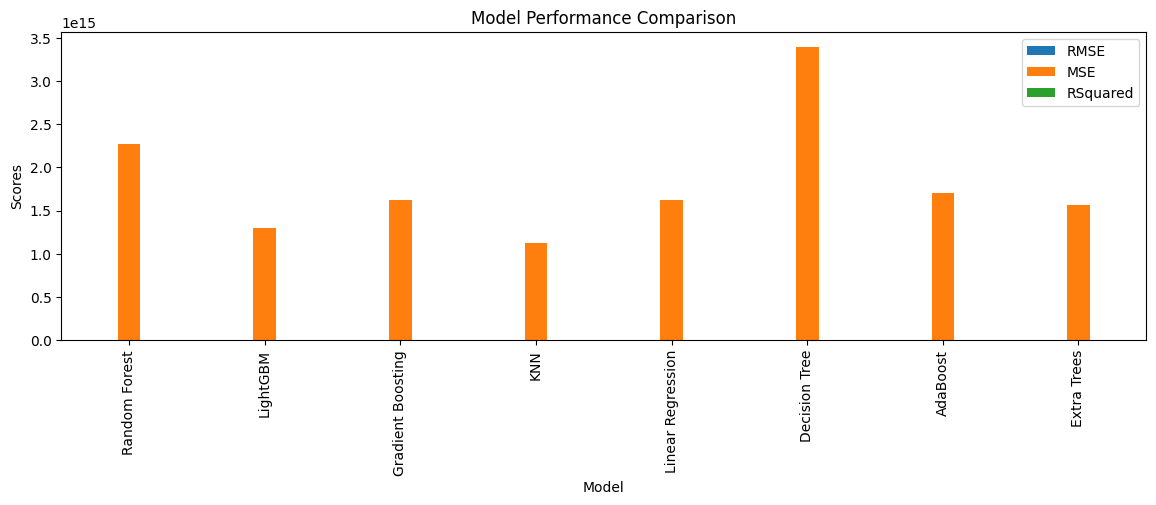

In [ ]:
output_dir = "../models/checkpoints/tuned/random/sale"
model_group = 'sale'

random_tuned_sale_metrics_df, random_tuned_sale_models = train_and_tune_models(
    X_train=X_train,
    X_val=X_val,
    y_train=y_train,
    y_val=y_val,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    models=models,
    tuning="random",  # Choose "grid", "random", or "bayesian"
    model_group=model_group,
    scoring="neg_mean_squared_error",
    early_stopping=True,
    cv=3,
    output_dir=output_dir
)

- tuned grid rental

Model 1: Estimating property rental prices using real estate transaction data only.

Training and tuning Random Forest model with 3-fold cross-validators...


Training Random Forest:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Random Forest and grid tuning...


Training Random Forest:  33%|███▎      | 1/3 [00:04<00:08,  4.28s/tree]

Performing Grid Search for Random Forest and grid tuning...


Training Random Forest:  67%|██████▋   | 2/3 [00:08<00:04,  4.23s/tree]

Performing Grid Search for Random Forest and grid tuning...


Training Random Forest: 100%|██████████| 3/3 [00:12<00:00,  4.26s/tree]


Best Random Forest saved at ../models/checkpoints/tuned/grid/rental/Random Forest/Random Forest_model.pkl.
Best parameters for Random Forest: {}
Best neg_mean_squared_error score: -29785568.0361

------------------------------------------------------------------------------------------------------------------------

Training and tuning LightGBM model with 3-fold cross-validators...


Training LightGBM:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for LightGBM and grid tuning...


Training LightGBM:  33%|███▎      | 1/3 [04:01<08:02, 241.13s/tree]

Performing Grid Search for LightGBM and grid tuning...


Training LightGBM:  67%|██████▋   | 2/3 [07:58<03:59, 239.04s/tree]

Performing Grid Search for LightGBM and grid tuning...


Training LightGBM: 100%|██████████| 3/3 [11:57<00:00, 239.04s/tree]


Best LightGBM saved at ../models/checkpoints/tuned/grid/rental/LightGBM/LightGBM_model.pkl.
Best parameters for LightGBM: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 150, 'regressor__num_leaves': 15}
Best neg_mean_squared_error score: -3554852.6053

------------------------------------------------------------------------------------------------------------------------

Training and tuning Gradient Boosting model with 3-fold cross-validators...


Training Gradient Boosting:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Gradient Boosting and grid tuning...


Training Gradient Boosting:  33%|███▎      | 1/3 [00:04<00:09,  4.77s/tree]

Performing Grid Search for Gradient Boosting and grid tuning...


Training Gradient Boosting:  67%|██████▋   | 2/3 [00:09<00:04,  4.67s/tree]

Performing Grid Search for Gradient Boosting and grid tuning...


Training Gradient Boosting: 100%|██████████| 3/3 [00:13<00:00,  4.65s/tree]


Best Gradient Boosting saved at ../models/checkpoints/tuned/grid/rental/Gradient Boosting/Gradient Boosting_model.pkl.
Best parameters for Gradient Boosting: {}
Best neg_mean_squared_error score: -566558076.4997

------------------------------------------------------------------------------------------------------------------------

Training and tuning KNN model with 3-fold cross-validators...


Training KNN:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for KNN and grid tuning...


Training KNN:  33%|███▎      | 1/3 [01:07<02:15, 67.98s/tree]

Performing Grid Search for KNN and grid tuning...


Training KNN:  67%|██████▋   | 2/3 [02:15<01:07, 67.94s/tree]

Performing Grid Search for KNN and grid tuning...


Training KNN: 100%|██████████| 3/3 [03:23<00:00, 67.83s/tree]


Best KNN saved at ../models/checkpoints/tuned/grid/rental/KNN/KNN_model.pkl.
Best parameters for KNN: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 3, 'regressor__weights': 'distance'}
Best neg_mean_squared_error score: -155690923.7141

------------------------------------------------------------------------------------------------------------------------

Training and tuning Linear Regression model with 3-fold cross-validators...


Training Linear Regression:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Linear Regression and grid tuning...


Training Linear Regression:  33%|███▎      | 1/3 [00:02<00:05,  2.51s/tree]

Performing Grid Search for Linear Regression and grid tuning...


Training Linear Regression:  67%|██████▋   | 2/3 [00:04<00:02,  2.46s/tree]

Performing Grid Search for Linear Regression and grid tuning...


Training Linear Regression: 100%|██████████| 3/3 [00:07<00:00,  2.48s/tree]


Best Linear Regression saved at ../models/checkpoints/tuned/grid/rental/Linear Regression/Linear Regression_model.pkl.
Best parameters for Linear Regression: {}
Best neg_mean_squared_error score: -304083169.1479

------------------------------------------------------------------------------------------------------------------------

Training and tuning Decision Tree model with 3-fold cross-validators...


Training Decision Tree:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Decision Tree and grid tuning...


Training Decision Tree:  33%|███▎      | 1/3 [00:03<00:07,  3.52s/tree]

Performing Grid Search for Decision Tree and grid tuning...


Training Decision Tree:  67%|██████▋   | 2/3 [00:07<00:03,  3.84s/tree]

Performing Grid Search for Decision Tree and grid tuning...


Training Decision Tree: 100%|██████████| 3/3 [00:11<00:00,  3.87s/tree]


Best Decision Tree saved at ../models/checkpoints/tuned/grid/rental/Decision Tree/Decision Tree_model.pkl.
Best parameters for Decision Tree: {}
Best neg_mean_squared_error score: -29491064.9629

------------------------------------------------------------------------------------------------------------------------

Training and tuning AdaBoost model with 3-fold cross-validators...


Training AdaBoost:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for AdaBoost and grid tuning...


Training AdaBoost:  33%|███▎      | 1/3 [40:19<1:20:38, 2419.38s/tree]

Performing Grid Search for AdaBoost and grid tuning...


Training AdaBoost:  67%|██████▋   | 2/3 [1:32:43<47:25, 2845.55s/tree]

Performing Grid Search for AdaBoost and grid tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Training AdaBoost: 100%|██████████| 3/3 [2:21:18<00:00, 2826.20s/tree]


Best AdaBoost saved at ../models/checkpoints/tuned/grid/rental/AdaBoost/AdaBoost_model.pkl.
Best parameters for AdaBoost: {'regressor__learning_rate': 0.05, 'regressor__loss': 'exponential', 'regressor__n_estimators': 50}
Best neg_mean_squared_error score: -9564627.6750

------------------------------------------------------------------------------------------------------------------------

Training and tuning Extra Trees model with 3-fold cross-validators...


Training Extra Trees:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Grid Search for Extra Trees and grid tuning...


Training Extra Trees:  33%|███▎      | 1/3 [00:04<00:09,  4.70s/tree]

Performing Grid Search for Extra Trees and grid tuning...


Training Extra Trees:  67%|██████▋   | 2/3 [00:09<00:04,  4.89s/tree]

Performing Grid Search for Extra Trees and grid tuning...


Training Extra Trees: 100%|██████████| 3/3 [00:14<00:00,  4.74s/tree]


Best Extra Trees saved at ../models/checkpoints/tuned/grid/rental/Extra Trees/Extra Trees_model.pkl.
Best parameters for Extra Trees: {}
Best neg_mean_squared_error score: -30382584.8338

------------------------------------------------------------------------------------------------------------------------
Performance metrics:
               Model          RMSE           MSE  RSquared  \
0      Random Forest   5940.323386  3.528744e+07  0.958502   
1           LightGBM   1187.722826  1.410686e+06  0.998341   
2  Gradient Boosting  22975.703416  5.278829e+08  0.379213   
3                KNN  10692.235820  1.143239e+08  0.865556   
4  Linear Regression  16329.277509  2.666453e+08  0.686427   
5      Decision Tree   5650.685385  3.193025e+07  0.962450   
6           AdaBoost   3225.838676  1.040604e+07  0.987763   
7        Extra Trees   3581.502604  1.282716e+07  0.984915   

                                         Best Params    Best Score  
0                                         

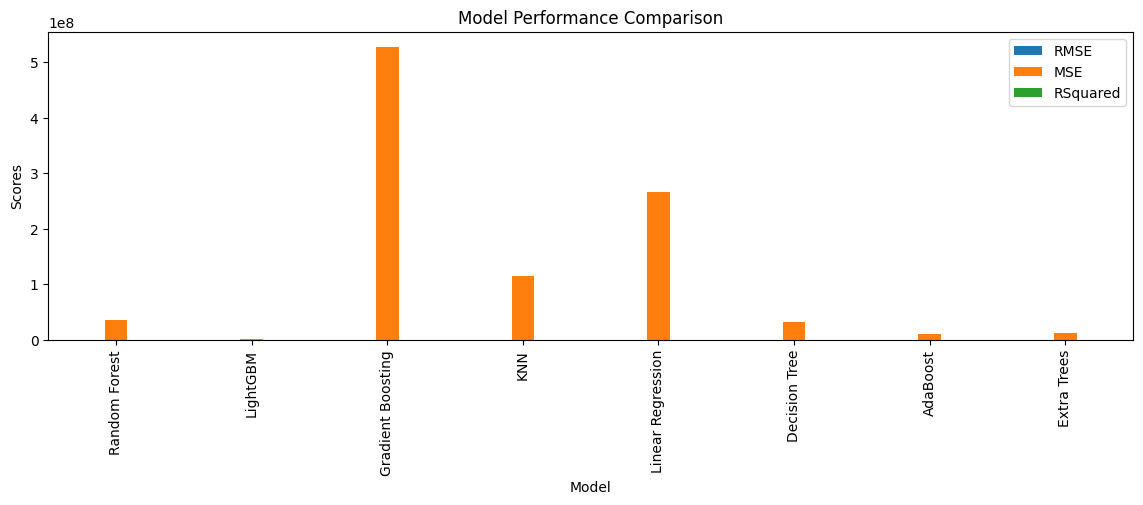

In [192]:
output_dir = "../models/checkpoints/tuned/grid/rental"
model_group = 'rental'

grid_tuned_rental_metrics_df, grid_tuned_rental_models = train_and_tune_models(
    X_train=X_train_rental,
    X_val=X_val_rental,
    y_train=y_train_rental,
    y_val=y_val_rental,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    models=models,
    tuning="grid",  # Choose "grid", "random", or "bayesian"
    model_group=model_group,
    scoring="neg_mean_squared_error",
    early_stopping=True,
    cv=3,
    output_dir=output_dir
)

- tuned randomized rental

Model 1: Estimating property rental prices using real estate transaction data only.

Training and tuning Random Forest model with 3-fold cross-validators...


Training Random Forest:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Random Forest and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Random Forest:  33%|███▎      | 1/3 [00:03<00:07,  4.00s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Random Forest and random tuning...


Training Random Forest:  67%|██████▋   | 2/3 [00:08<00:04,  4.20s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Random Forest and random tuning...


Training Random Forest: 100%|██████████| 3/3 [00:12<00:00,  4.19s/tree]


Best Random Forest saved at ../models/checkpoints/tuned/random/rental/Random Forest/Random Forest_model.pkl.
Best parameters for Random Forest: {}
Best neg_mean_squared_error score: -29785568.0361

------------------------------------------------------------------------------------------------------------------------

Training and tuning LightGBM model with 3-fold cross-validators...


Training LightGBM:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for LightGBM and random tuning...


Training LightGBM:  33%|███▎      | 1/3 [02:13<04:27, 133.57s/tree]

Performing Randomized Search for LightGBM and random tuning...


Training LightGBM:  67%|██████▋   | 2/3 [04:26<02:13, 133.13s/tree]

Performing Randomized Search for LightGBM and random tuning...


Training LightGBM: 100%|██████████| 3/3 [06:42<00:00, 134.02s/tree]


Best LightGBM saved at ../models/checkpoints/tuned/random/rental/LightGBM/LightGBM_model.pkl.
Best parameters for LightGBM: {'regressor__learning_rate': 0.17167946962329225, 'regressor__max_depth': 11, 'regressor__n_estimators': 139, 'regressor__num_leaves': 16}
Best neg_mean_squared_error score: -3914113.5458

------------------------------------------------------------------------------------------------------------------------

Training and tuning Gradient Boosting model with 3-fold cross-validators...


Training Gradient Boosting:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Gradient Boosting and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Gradient Boosting:  33%|███▎      | 1/3 [00:04<00:09,  4.94s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Gradient Boosting and random tuning...


Training Gradient Boosting:  67%|██████▋   | 2/3 [00:11<00:05,  5.68s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Gradient Boosting and random tuning...


Training Gradient Boosting: 100%|██████████| 3/3 [00:15<00:00,  5.17s/tree]


Best Gradient Boosting saved at ../models/checkpoints/tuned/random/rental/Gradient Boosting/Gradient Boosting_model.pkl.
Best parameters for Gradient Boosting: {}
Best neg_mean_squared_error score: -566558076.4997

------------------------------------------------------------------------------------------------------------------------

Training and tuning KNN model with 3-fold cross-validators...


Training KNN:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for KNN and random tuning...


Training KNN:  33%|███▎      | 1/3 [02:07<04:15, 127.80s/tree]

Performing Randomized Search for KNN and random tuning...


Training KNN:  67%|██████▋   | 2/3 [04:17<02:09, 129.18s/tree]

Performing Randomized Search for KNN and random tuning...


Training KNN: 100%|██████████| 3/3 [06:29<00:00, 129.92s/tree]


Best KNN saved at ../models/checkpoints/tuned/random/rental/KNN/KNN_model.pkl.
Best parameters for KNN: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 4, 'regressor__weights': 'distance'}
Best neg_mean_squared_error score: -157561594.7269

------------------------------------------------------------------------------------------------------------------------

Training and tuning Linear Regression model with 3-fold cross-validators...


Training Linear Regression:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Linear Regression and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Linear Regression:  33%|███▎      | 1/3 [00:02<00:05,  2.57s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Linear Regression and random tuning...


Training Linear Regression:  67%|██████▋   | 2/3 [00:05<00:02,  2.64s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Linear Regression and random tuning...


Training Linear Regression: 100%|██████████| 3/3 [00:07<00:00,  2.58s/tree]


Best Linear Regression saved at ../models/checkpoints/tuned/random/rental/Linear Regression/Linear Regression_model.pkl.
Best parameters for Linear Regression: {}
Best neg_mean_squared_error score: -304083169.1479

------------------------------------------------------------------------------------------------------------------------

Training and tuning Decision Tree model with 3-fold cross-validators...


Training Decision Tree:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Decision Tree and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Decision Tree:  33%|███▎      | 1/3 [00:03<00:07,  3.68s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Decision Tree and random tuning...


Training Decision Tree:  67%|██████▋   | 2/3 [00:07<00:03,  3.71s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Decision Tree and random tuning...


Training Decision Tree: 100%|██████████| 3/3 [00:11<00:00,  3.70s/tree]


Best Decision Tree saved at ../models/checkpoints/tuned/random/rental/Decision Tree/Decision Tree_model.pkl.
Best parameters for Decision Tree: {}
Best neg_mean_squared_error score: -29491064.9629

------------------------------------------------------------------------------------------------------------------------

Training and tuning AdaBoost model with 3-fold cross-validators...


Training AdaBoost:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for AdaBoost and random tuning...


Training AdaBoost:  33%|███▎      | 1/3 [24:38<49:17, 1478.86s/tree]

Performing Randomized Search for AdaBoost and random tuning...


Training AdaBoost:  67%|██████▋   | 2/3 [49:43<24:53, 1493.95s/tree]

Performing Randomized Search for AdaBoost and random tuning...


Training AdaBoost: 100%|██████████| 3/3 [1:15:10<00:00, 1503.43s/tree]


Best AdaBoost saved at ../models/checkpoints/tuned/random/rental/AdaBoost/AdaBoost_model.pkl.
Best parameters for AdaBoost: {'regressor__learning_rate': 0.013193250444042839, 'regressor__loss': 'square', 'regressor__n_estimators': 133}
Best neg_mean_squared_error score: -9893076.3702

------------------------------------------------------------------------------------------------------------------------

Training and tuning Extra Trees model with 3-fold cross-validators...


Training Extra Trees:   0%|          | 0/3 [00:00<?, ?tree/s]

Performing Randomized Search for Extra Trees and random tuning...


/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Training Extra Trees:  33%|███▎      | 1/3 [00:04<00:09,  4.63s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Extra Trees and random tuning...


Training Extra Trees:  67%|██████▋   | 2/3 [00:09<00:04,  4.70s/tree]/Users/okpo/Desktop/Onward/dubai_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing Randomized Search for Extra Trees and random tuning...


Training Extra Trees: 100%|██████████| 3/3 [00:14<00:00,  4.67s/tree]


Best Extra Trees saved at ../models/checkpoints/tuned/random/rental/Extra Trees/Extra Trees_model.pkl.
Best parameters for Extra Trees: {}
Best neg_mean_squared_error score: -30382584.8338

------------------------------------------------------------------------------------------------------------------------
Performance metrics:
               Model          RMSE           MSE  RSquared  \
0      Random Forest   5940.323386  3.528744e+07  0.958502   
1           LightGBM   1138.113113  1.295301e+06  0.998477   
2  Gradient Boosting  22975.703416  5.278829e+08  0.379213   
3                KNN  10747.841339  1.155161e+08  0.864154   
4  Linear Regression  16329.277509  2.666453e+08  0.686427   
5      Decision Tree   5650.685385  3.193025e+07  0.962450   
6           AdaBoost   3275.808198  1.073092e+07  0.987380   
7        Extra Trees   3581.502604  1.282716e+07  0.984915   

                                         Best Params    Best Score  
0                                       

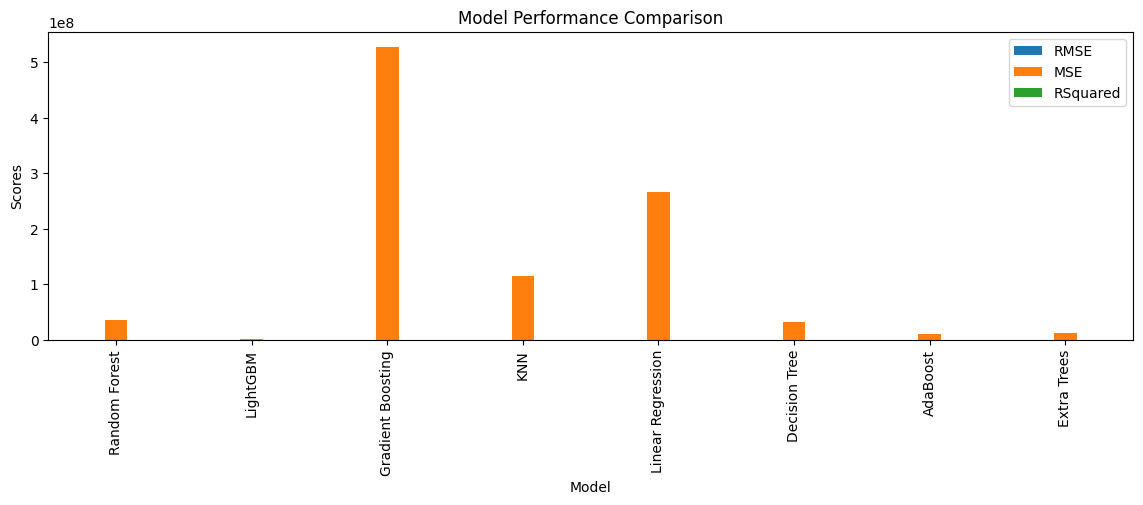

In [193]:
output_dir = "../models/checkpoints/tuned/random/rental"
model_group = 'rental'

random_tuned_rental_metrics_df, random_tuned_rental_models = train_and_tune_models(
    X_train=X_train_rental,
    X_val=X_val_rental,
    y_train=y_train_rental,
    y_val=y_val_rental,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    models=models,
    tuning="random",  # Choose "grid", "random", or "bayesian"
    model_group=model_group,
    scoring="neg_mean_squared_error",
    early_stopping=True,
    cv=3,
    output_dir=output_dir
)

In [100]:
# sns.barplot(data=metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), x="Metric", y="Score", hue="Model")
melted_tuned_sale_metrics_df = tuned_sale_metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
melted_tuned_sale_metrics_df
# tuned_sale_metrics_df

,Model,Metric,Score
0,LightGBM,RMSE,37527869.686714
1,LightGBM,MSE,1408341003223010.0
2,LightGBM,R²,0.146179
3,LightGBM,Best Params,"{'regressor__learning_rate': 0.1, 'regressor__..."


In [ ]:
plt.figure(figsize=(14, 4))
sns.barplot(data=melted_tuned_sale_metrics_df, x="Metric", y="Score", hue="Model")
plt.title("Model Performance Metrics")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import pandas as pd
from tqdm import tqdm

def train_and_evaluate_models_regression(df, features, target, model_choices=None):
    """
    Training pipeline for regression models with grid search and cross-validation.
    
    Args:
        df (DataFrame): Dataset containing features and target.
        features (list): List of feature names.
        target (str): Target column name.
        model_choices (list): List of model names to train and evaluate.
    
    Returns:
        metrics_df (DataFrame): Summary of model performances.
        best_models (dict): Best models with their tuned hyperparameters.
    """
    metrics = []
    best_models = {}

    # Prepare dataset
    data = df[features + [target]].dropna()
    X = data[features]
    y = data[target]

    # Data preprocessing
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Cross-validation setup
    cv = 5  # Number of folds for cross-validation

    # Models to train
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(random_state=42),
        'SVR': SVR(),
        'XGBoost': XGBRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42),
        'KNN': KNeighborsRegressor(),
        'ExtraTrees': ExtraTreesRegressor(random_state=42),
        'LightGBM': LGBMRegressor(random_state=42)
    }

    # Iterate over models with tqdm for progress tracking
    for model_name in tqdm(model_choices, desc="Training Models"):
        if model_name not in models:
            print(f"Model {model_name} not found. Skipping...")
            continue

        model = models[model_name]

        # Define hyperparameters for each model
        param_grid = {}
        if model_name == 'RandomForest':
            param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
        elif model_name == 'SVR':
            param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        elif model_name == 'XGBoost':
            param_grid = {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200], 'max_depth': [3, 5, 7]}
        elif model_name == 'GradientBoosting':
            param_grid = {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200], 'max_depth': [3, 5, 7]}
        elif model_name == 'AdaBoost':
            param_grid = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]}
        elif model_name == 'KNN':
            param_grid = {'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance']}
        elif model_name == 'ExtraTrees':
            param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10, 20, None]}
        elif model_name == 'LightGBM':
            param_grid = {'learning_rate': [0.01, 0.1], 'verbosity':[-1], 'n_estimators': [100, 200], 'max_depth': [3, 5, 7]}

        # Grid Search with cross-validation
        grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
        grid.fit(X_scaled, y)
        best_model = grid.best_estimator_

        # Store best model parameters
        best_models[model_name] = grid.best_params_

        # Cross-validation scores
        cv_scores = -grid.best_score_  # Negative MSE to positive MSE
        rmse_cv = np.sqrt(cv_scores)
        print(f"\n{model_name} Cross-Validation RMSE: {rmse_cv:.4f}")

        # Test predictions (use entire dataset here for demonstration)
        y_pred = best_model.predict(X_scaled)
        rmse_test = np.sqrt(mean_squared_error(y, y_pred))
        mae_test = mean_absolute_error(y, y_pred)
        r2_test = r2_score(y, y_pred)
        print(f"{model_name} Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

        metrics.append({
            'Model': model_name,
            'CV RMSE': rmse_cv,
            'Test RMSE': rmse_test,
            'Test MAE': mae_test,
            'Test R²': r2_test
        })

    metrics_df = pd.DataFrame(metrics)
    return metrics_df, best_models


target_sale = 'Sale Price'
target_rental = 'Annual Rental Price'
features = sales_model_features_df.columns.difference([target_sale, target_rental])

models = ['SVR', 'XGBoost', 'LightGBM','LinearRegression', 'RandomForest', 'GradientBoosting', 'KNN']
metrics_df, best_models = train_and_evaluate_models_regression(
    df=sales_model_features_df,
    features=['Property Size (sq.m)', 'Number of Rooms', 'Avg Price per sq.m Last Month'],
    target=target_sale,
    model_choices=models
)

metrics_df



In [ ]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# import pandas as pd
# import numpy as np
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# def train_and_evaluate_models_with_categorical(df, features, target, cat_features=None, model_choices=None):
#     """
#     Training pipeline for regression models with grid search, cross-validation, and categorical data handling.
    
#     Args:
#         df (DataFrame): Dataset containing features and target.
#         features (list): List of feature names.
#         target (str): Target column name.
#         cat_features (list): List of categorical feature names (subset of features).
#         model_choices (list): List of model names to train and evaluate.
    
#     Returns:
#         metrics_df (DataFrame): Summary of model performances.
#         best_models (dict): Best models with their tuned hyperparameters.
#     """
#     metrics = []
#     best_models = {}

#     # Prepare dataset
#     data = df[features + [target]].dropna()
#     X = data[features]
#     y = data[target]

#     # Separate numerical and categorical features
#     cat_features = cat_features or []
#     num_features = list(set(features) - set(cat_features))

#     # Preprocessing for numeric and categorical data
#     num_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='mean')),
#         ('scaler', StandardScaler())
#     ])
#     cat_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore'))
#     ])

#     # Combine preprocessors in a column transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', num_transformer, num_features),
#             ('cat', cat_transformer, cat_features)
#         ]
#     )

#     # Models to train
#     models = {
#         'LinearRegression': LinearRegression(),
#         'RandomForest': RandomForestRegressor(random_state=42),
#         'SVR': SVR(),
#         'XGBoost': XGBRegressor(random_state=42),
#         'GradientBoosting': GradientBoostingRegressor(random_state=42),
#         'AdaBoost': AdaBoostRegressor(random_state=42),
#         'KNN': KNeighborsRegressor(),
#         'LightGBM': LGBMRegressor(random_state=42)
#     }

#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Iterate over models with tqdm for progress tracking
#     for model_name in tqdm(model_choices, desc="Training Models"):
#         if model_name not in models:
#             print(f"Model {model_name} not found. Skipping...")
#             continue

#         model = models[model_name]

#         # Define a minimal parameter grid for each model
#         param_grid = {}
#         if model_name == 'RandomForest':
#             param_grid = {'n_estimators': [10, 50], 'max_depth': [3, None]}
#         elif model_name == 'SVR':
#             param_grid = {'C': [0.1, 1], 'kernel': ['linear']}
#         elif model_name == 'XGBoost':
#             param_grid = {'learning_rate': [0.1], 'n_estimators': [10, 50], 'max_depth': [3]}
#         elif model_name == 'GradientBoosting':
#             param_grid = {'learning_rate': [0.1], 'n_estimators': [10, 50], 'max_depth': [3]}
#         elif model_name == 'KNN':
#             param_grid = {'n_neighbors': [3, 5], 'weights': ['uniform']}
#         elif model_name == 'LightGBM':
#             param_grid = {'learning_rate': [0.1], 'n_estimators': [10, 50], 'max_depth': [3]}

#         # Create pipeline with preprocessor and model
#         pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

#         # Grid Search with cross-validation
#         grid = GridSearchCV(pipeline, {'model__' + k: v for k, v in param_grid.items()},
#                             cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
#         grid.fit(X_train, y_train)
#         best_model = grid.best_estimator_

#         # Store best model parameters
#         best_models[model_name] = grid.best_params_

#         # Test predictions
#         y_pred = best_model.predict(X_test)
#         rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
#         mae_test = mean_absolute_error(y_test, y_pred)
#         r2_test = r2_score(y_test, y_pred)
#         print(f"\n{model_name} Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

#         metrics.append({
#             'Model': model_name,
#             'Test RMSE': rmse_test,
#             'Test MAE': mae_test,
#             'Test R²': r2_test
#         })

#     # Compile metrics
#     metrics_df = pd.DataFrame(metrics)

#     # Visualize results
#     metrics_df.set_index('Model')[['Test RMSE', 'Test MAE']].plot(kind='bar', figsize=(12, 6))
#     plt.title("Model Performance Comparison")
#     plt.ylabel("Error")
#     plt.show()

#     return metrics_df, best_models

# features = ['Property Size (sq.m)', 'Number of Rooms', 'Area']
# cat_features = ['Area']
# target = 'Sale Price'

# target_sale = 'Sale Price'
# target_rental = 'Annual Rental Price'
# # features = model_features_df.columns.difference([target_sale, target_rental])


# models = ['LinearRegression', 'RandomForest', 'XGBoost', 'GradientBoosting', 'LightGBM']
# metrics_df, best_models = train_and_evaluate_models_with_categorical(
#     df=model_features_df,
#     features=features,
#     target=target,
#     cat_features=cat_features,
#     model_choices=models
# )


# metrics_df



In [ ]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.preprocessing import StandardScaler
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# import optuna
# import pandas as pd
# from tqdm import tqdm
# import numpy as np

# def train_and_evaluate_models_regression_advanced(df, features, target, model_choices=None):
#     """
#     Advanced training pipeline for regression models with Bayesian Optimization, Randomized Search, and Early Stopping.
    
#     Args:
#         df (DataFrame): Dataset containing features and target.
#         features (list): List of feature names.
#         target (str): Target column name.
#         model_choices (list): List of model names to train and evaluate.
    
#     Returns:
#         metrics_df (DataFrame): Summary of model performances.
#         best_models (dict): Best models with their tuned hyperparameters.
#     """
#     metrics = []
#     best_models = {}

#     # Prepare dataset
#     data = df[features + [target]].dropna()
#     X = data[features]
#     y = data[target]

#     # Data preprocessing
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     # Train-test split
#     X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#     # Models to train
#     models = {
#         'LinearRegression': LinearRegression(),
#         'RandomForest': RandomForestRegressor(random_state=42),
#         'SVR': SVR(),
#         'XGBoost': XGBRegressor(random_state=42),
#         'GradientBoosting': GradientBoostingRegressor(random_state=42),
#         'AdaBoost': AdaBoostRegressor(random_state=42),
#         'KNN': KNeighborsRegressor(),
#         'LightGBM': LGBMRegressor(random_state=42)
#     }

#     # Hyperparameter tuning with Optuna
#     def optuna_objective(trial, model_name, model):
#         param_grid = {}
#         if model_name == 'RandomForest':
#             param_grid = {
#                 'n_estimators': trial.suggest_int('n_estimators', 10, 100),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#             }
#         elif model_name == 'SVR':
#             param_grid = {
#                 'C': trial.suggest_loguniform('C', 0.1, 10),
#                 'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
#             }
#         elif model_name == 'XGBoost':
#             param_grid = {
#                 'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
#                 'n_estimators': trial.suggest_int('n_estimators', 10, 100),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#             }
#         elif model_name == 'GradientBoosting':
#             param_grid = {
#                 'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
#                 'n_estimators': trial.suggest_int('n_estimators', 10, 100),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#             }
#         elif model_name == 'KNN':
#             param_grid = {
#                 'n_neighbors': trial.suggest_int('n_neighbors', 3, 10),
#                 'weights': trial.suggest_categorical('weights', ['uniform', 'distance'])
#             }
#         elif model_name == 'LightGBM':
#             param_grid = {
#                 'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
#                 'n_estimators': trial.suggest_int('n_estimators', 10, 100),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#             }
        
#         model.set_params(**param_grid)
#         model.fit(X_train, y_train)
#         preds = model.predict(X_val)
#         rmse = mean_squared_error(y_val, preds, squared=False)
#         return rmse

#     # Iterate over models
#     for model_name in tqdm(model_choices, desc="Training Models"):
#         if model_name not in models:
#             print(f"Model {model_name} not found. Skipping...")
#             continue

#         model = models[model_name]

#         # Bayesian Optimization using Optuna
#         study = optuna.create_study(direction='minimize')
#         study.optimize(lambda trial: optuna_objective(trial, model_name, model), n_trials=10)

#         # Best hyperparameters and final model
#         best_params = study.best_params
#         best_models[model_name] = best_params
#         model.set_params(**best_params)

#         # Early stopping for applicable models
#         if model_name in ['XGBoost', 'GradientBoosting', 'LightGBM']:
#             model.fit(
#                 X_train, y_train,
#                 eval_set=[(X_val, y_val)],
#                 eval_metric='rmse',
#                 early_stopping_rounds=10,
#                 verbose=False
#             )
#         else:
#             model.fit(X_train, y_train)

#         # Test predictions
#         y_pred = model.predict(X_val)
#         rmse = mean_squared_error(y_val, y_pred, squared=False)
#         mae = mean_absolute_error(y_val, y_pred)
#         r2 = r2_score(y_val, y_pred)

#         metrics.append({
#             'Model': model_name,
#             'RMSE': rmse,
#             'MAE': mae,
#             'R²': r2
#         })

#     metrics_df = pd.DataFrame(metrics)
#     return metrics_df, best_models


# features = ['Property Size (sq.m)', 'Number of Rooms', 'Avg Price per sq.m Last Month']
# target = 'Sale Price'

# models = [ 'LightGBM', 'KNN', 'SVR','RandomForest', 'XGBoost', 'GradientBoosting',]
# metrics_df, best_models = train_and_evaluate_models_regression_advanced(
#     df=model_features_df,
#     features=features,
#     target=target,
#     model_choices=models
# )

# print(metrics_df)
# print("Best Hyperparameters:", best_models)


In [ ]:
print('model_features_df:', sales_model_features_df.columns)
print('categorical features:', categorical_features)
print('numerical features:', numerical_features)